In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import time
import requests
import matplotlib.pyplot as plt
import string

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.preprocessing import StandardScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer


from skopt.space import Integer, Real, Categorical
from skopt import BayesSearchCV
from scipy.stats import uniform, loguniform

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [2]:
# epoch_time = 1627664412

# dj_all = pd.DataFrame()
# column_list = ['title', 'selftext', 'subreddit','created_utc', 'author', 'num_comments', 'score', 'is_self']
# while dj_all.shape[0] < 6000:
#     url_dj = f"https://api.pushshift.io/reddit/search/submission?subreddit=dadjokes&size=100&before={epoch_time}"
#     res_dj = requests.get(url_dj)
#     if res_dj.status_code != 200:
#         print("ruh roh... sleep and retry")
#         failed +=1
#         if failed >=3:
#             print('Big ruh roh')
#             break
#         time.sleep(5)
#         continue
#     failed = 0

#     dj_temp = pd.DataFrame(res_dj.json()['data'])[column_list]
#     #print(dj_temp.shape)
#     epoch_time = dj_temp['created_utc'].min()
#     time.sleep(5)
#     dj_all = pd.concat([dj_all,dj_temp])
#     #print(dj_all.shape)
#     dj_all.drop_duplicates('selftext',keep='last',inplace=True)
    
#     print(epoch_time,dj_all.shape[0])

In [3]:
# epoch_time = 1627664412
# aj_all = pd.DataFrame()

# failed = 0
# while aj_all.shape[0] < 6000:
#     url_aj = f"https://api.pushshift.io/reddit/search/submission?subreddit=AntiJokes&size=100&before={epoch_time}"
#     res_aj = requests.get(url_aj)
#     if res_aj.status_code != 200:
#         print("ruh roh... sleep and retry")
#         failed +=1
#         if failed >=3:
#             print('Big ruh roh')
#             break
#         time.sleep(5)
#         continue
#     failed = 0
#     aj_temp = pd.DataFrame(res_aj.json()['data'])[column_list]
#     #print(dj_temp.shape)
#     epoch_time = aj_temp['created_utc'].min()
#     time.sleep(5)
#     aj_all = pd.concat([aj_all,aj_temp])
#     #print(dj_all.shape)
#     aj_all.drop_duplicates('selftext',keep='last',inplace=True)
    
#     print(epoch_time,aj_all.shape[0])


In [4]:
# jokes_all = pd.concat([dj_all,aj_all])
# jokes_all['full_text'] = jokes_all['title'] + " " + jokes_all['selftext']
# jokes_all = jokes_all[(jokes_all['selftext'] != '[deleted]') & (jokes_all['selftext'] != '[removed]')]
# jokes_all.dropna(inplace=True)
# jokes_all.to_csv('../data/jokes.csv')

In [5]:
jokes_all = pd.read_csv('../data/jokes.csv')

In [6]:
jokes_all['dad'] = jokes_all['subreddit'].map(lambda x: 1 if x == 'dadjokes' else 0)
jokes_all.head()

,Unnamed: 0,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,full_text,dad
0,0,Anybody know that show Naked and Afraid?,That's what I call hide and seek with my uncle...,dadjokes,1627664369,Moose908H,3,1,True,Anybody know that show Naked and Afraid? That'...,1
1,1,You don't need a therapist....,A 5 year old will tell you everything that's w...,dadjokes,1627664264,VERBERD,2,1,True,You don't need a therapist.... A 5 year old wi...,1
2,2,Why are fizzy drinks so tasty?,They are soda-licious,dadjokes,1627664007,techtornado,3,1,True,Why are fizzy drinks so tasty? They are soda-l...,1
3,3,I tried drag racing the other day,It's brutal running in those heels!,dadjokes,1627662305,Moose908H,1,1,True,I tried drag racing the other day It's brutal ...,1
4,4,"In the next season of Ozark, Marty becomes the...",Byrde is the Word,dadjokes,1627661919,DinglebarryHandpump,0,1,True,"In the next season of Ozark, Marty becomes the...",1


In [7]:
lemmatizer = WordNetLemmatizer()
def lemonize(text):
    text_l = text.split()
    for i in range(len(text_l)):
        text_l[i] = lemmatizer.lemmatize(text_l[i])
    return ' '.join(text_l)

jokes_all['lemon'] = jokes_all['full_text'].map(lemonize)
jokes_all[['full_text','lemon']].head()

,full_text,lemon
0,Anybody know that show Naked and Afraid? That'...,Anybody know that show Naked and Afraid? That'...
1,You don't need a therapist.... A 5 year old wi...,You don't need a therapist.... A 5 year old wi...
2,Why are fizzy drinks so tasty? They are soda-l...,Why are fizzy drink so tasty? They are soda-li...
3,I tried drag racing the other day It's brutal ...,I tried drag racing the other day It's brutal ...
4,"In the next season of Ozark, Marty becomes the...","In the next season of Ozark, Marty becomes the..."


In [8]:
p_stemmer = PorterStemmer()
def porter(text):
    text_l = text.split()
    for i in range(len(text_l)):
        text_l[i] = p_stemmer.stem(text_l[i])
    return ' '.join(text_l)


In [9]:
jokes_all['ft_length'] = jokes_all['full_text'].map(lambda x: len(x))
jokes_all['ft_wc'] = jokes_all['full_text'].map(lambda x: len([x.split()]))


In [10]:
sent = SentimentIntensityAnalyzer()
jokes_all['sent_compound'] = [sent.polarity_scores(x)['compound'] for x in jokes_all['full_text']]
jokes_all['sent_neg'] = [sent.polarity_scores(x)['neg'] for x in jokes_all['full_text']]
jokes_all['sent_neu'] = [sent.polarity_scores(x)['neu'] for x in jokes_all['full_text']]
jokes_all['sent_pos'] = [sent.polarity_scores(x)['pos'] for x in jokes_all['full_text']]
jokes_all.head()

,Unnamed: 0,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,full_text,dad,lemon,ft_length,ft_wc,sent_compound,sent_neg,sent_neu,sent_pos
0,0,Anybody know that show Naked and Afraid?,That's what I call hide and seek with my uncle...,dadjokes,1627664369,Moose908H,3,1,True,Anybody know that show Naked and Afraid? That'...,1,Anybody know that show Naked and Afraid? That'...,91,1,-0.1779,0.096,0.904,0.0
1,1,You don't need a therapist....,A 5 year old will tell you everything that's w...,dadjokes,1627664264,VERBERD,2,1,True,You don't need a therapist.... A 5 year old wi...,1,You don't need a therapist.... A 5 year old wi...,104,1,-0.4767,0.171,0.829,0.0
2,2,Why are fizzy drinks so tasty?,They are soda-licious,dadjokes,1627664007,techtornado,3,1,True,Why are fizzy drinks so tasty? They are soda-l...,1,Why are fizzy drink so tasty? They are soda-li...,52,1,0.0000,0.000,1.000,0.0
3,3,I tried drag racing the other day,It's brutal running in those heels!,dadjokes,1627662305,Moose908H,1,1,True,I tried drag racing the other day It's brutal ...,1,I tried drag racing the other day It's brutal ...,69,1,-0.7424,0.386,0.614,0.0
4,4,"In the next season of Ozark, Marty becomes the...",Byrde is the Word,dadjokes,1627661919,DinglebarryHandpump,0,1,True,"In the next season of Ozark, Marty becomes the...",1,"In the next season of Ozark, Marty becomes the...",72,1,0.0000,0.000,1.000,0.0


In [11]:
jokes_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12087 entries, 0 to 12086
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     12087 non-null  int64  
 1   title          12087 non-null  object 
 2   selftext       12087 non-null  object 
 3   subreddit      12087 non-null  object 
 4   created_utc    12087 non-null  int64  
 5   author         12087 non-null  object 
 6   num_comments   12087 non-null  int64  
 7   score          12087 non-null  int64  
 8   is_self        12087 non-null  bool   
 9   full_text      12087 non-null  object 
 10  dad            12087 non-null  int64  
 11  lemon          12087 non-null  object 
 12  ft_length      12087 non-null  int64  
 13  ft_wc          12087 non-null  int64  
 14  sent_compound  12087 non-null  float64
 15  sent_neg       12087 non-null  float64
 16  sent_neu       12087 non-null  float64
 17  sent_pos       12087 non-null  float64
dtypes: boo

In [12]:
jokes_all['porter'] = jokes_all['full_text'].map(porter)
jokes_all[['full_text','porter']].head()

,full_text,porter
0,Anybody know that show Naked and Afraid? That'...,anybodi know that show nake and afraid? that' ...
1,You don't need a therapist.... A 5 year old wi...,you don't need a therapist.... a 5 year old wi...
2,Why are fizzy drinks so tasty? They are soda-l...,whi are fizzi drink so tasty? they are soda-lici
3,I tried drag racing the other day It's brutal ...,i tri drag race the other day it' brutal run i...
4,"In the next season of Ozark, Marty becomes the...","in the next season of ozark, marti becom the m..."


In [13]:
X = jokes_all['full_text']
y = jokes_all['dad']
X_dj = jokes_all[jokes_all['dad'] == 1]['full_text']
y_dj = jokes_all[jokes_all['dad'] == 1]['dad']
X_aj = jokes_all[jokes_all['dad'] == 0]['full_text']
y_aj = jokes_all[jokes_all['dad'] == 0]['dad']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [14]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [15]:
cvec_dj = CountVectorizer(stop_words='english')
Xcv_dj = cvec_dj.fit_transform(X_dj,y_dj)
Xcv_djdf = pd.DataFrame(Xcv_dj.todense(),columns=cvec_dj.get_feature_names())
Xcv_djdf.head()

,00,000,01k,02,05,07,0mg,0nsznmdxnzu,10,100,...,𝒊𝒏,𝒍𝒊𝒌𝒆𝒏𝒆𝒅,𝒑𝒉𝒂𝒓𝒂𝒐𝒉,𝒕𝒉𝒆,𝒕𝒐,𝒚𝒐𝒖𝒏𝒈𝒆𝒔𝒕,𝙏𝙤𝙤𝙩,𝙖𝙣,𝙘𝙤𝙢𝙢𝙤𝙣,𝙞𝙣
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

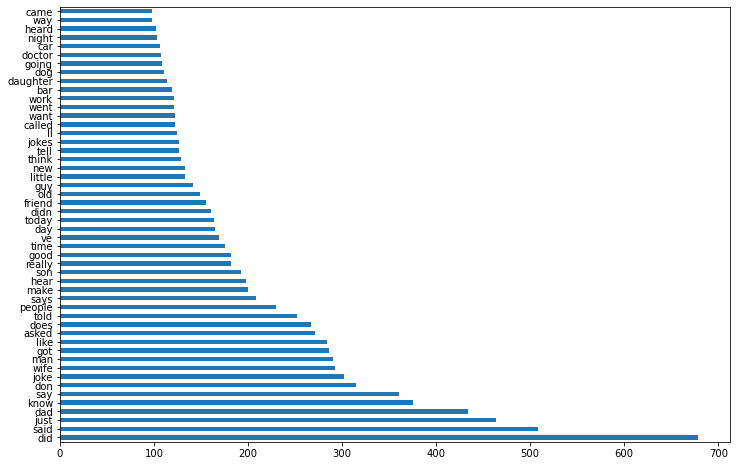

In [16]:
fig = plt.figure(figsize=(12,8))
Xcv_djdf.sum().sort_values(ascending=False).head(50).plot(kind='barh')

In [17]:
cvec_aj = CountVectorizer(stop_words='english')
Xcv_aj = cvec_aj.fit_transform(X_aj,y_aj)
Xcv_ajdf = pd.DataFrame(Xcv_aj.todense(),columns=cvec_aj.get_feature_names())
Xcv_ajdf.head()

,00,000,00000000000000000000000000000001,00100000,003,006,00653875954571505539843239754513915896150297878399377056071435169747221107988,007,01,01100001,...,𝗺𝗶𝘀𝗹𝗲𝗮𝗱𝗶𝗻𝗴,𝗺𝗼𝗿𝗻𝗶𝗻𝗴,𝘀𝗮𝘆,𝘀𝗼𝘂𝗿𝗰𝗲𝘀,𝘀𝘁𝗮𝘁𝗲𝗱,𝘁𝗴𝗲𝘂𝗿,𝘁𝗵𝗲,𝘁𝗵𝗶𝘀,𝘁𝗼,𝘄𝗼𝗿𝗸𝗲𝗿
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

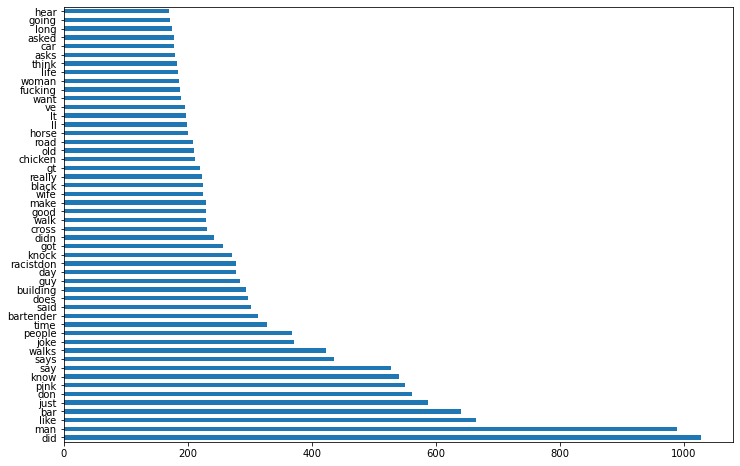

In [18]:
fig = plt.figure(figsize=(12,8))
Xcv_ajdf.sum().sort_values(ascending=False).head(50).plot(kind='barh')

In [19]:
top50_aj = list(Xcv_ajdf.sum().sort_values(ascending=False).head(50).index)
top50_dj = list(Xcv_djdf.sum().sort_values(ascending=False).head(50).index)
top100_aj = list(Xcv_ajdf.sum().sort_values(ascending=False).head(100).index)
top100_dj = list(Xcv_djdf.sum().sort_values(ascending=False).head(100).index)


In [20]:
stop_dad = ['dad','son','daughter','son','anti','antijokes','antijoke']
english_stop = list(stopwords.words('english')) + stop_dad

In [21]:
stop_50, stop_100 = stop_dad[:], stop_dad[:]
for aj in top50_aj:
    if aj in top50_dj:
        stop_50.append(aj)
for aj in top100_aj:
    if aj in top100_dj:
        stop_100.append(aj)
        


In [19]:
pipe_cvnb = Pipeline([
    ('cvec', CountVectorizer() ),
    ('nb', MultinomialNB())
])
pipe_cvnb_params = {
    'cvec__max_features': [5000,6000,7000],
    'cvec__min_df': [3,5,7],
    'cvec__stop_words': [stop_dad,stop_50,stop_100],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)]
}

In [73]:
gs = GridSearchCV(pipe_cvnb,pipe_cvnb_params,cv =5,verbose=10)
gs.fit(X_train,y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.699, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.693, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.696, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.706, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.705, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.692, total

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.1s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.697, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.4s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.707, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.6s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.688, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.683, total=   0.5s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.691, total=   0.5s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.684, total=   0.9s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.695, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.694, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.692, total=   0.5s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.683, total=   1.0s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.688, total=   1.0s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.679, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.693, total=   0.5s
[CV] cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.673, total=   0.5s
[CV] cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['da

[CV]  cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.674, total=   0.9s
[CV] cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.699, total=   0.2s
[CV] cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.689, total=   0.5s
[CV] cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.693, total=   0.5s
[CV] cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.697, total=   0.5s
[CV] cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.697, total=   0.5s
[CV] cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.695, total=   0.9s
[CV] cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.685, total=   0.2s
[CV] cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.699, total=   0.2s
[CV] cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.699, total=   0.2s
[CV] cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.694, total=   0.2s
[CV] cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.695, total=   0.5s
[CV] cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.683, total=   0.9s
[CV] cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.697, total=   0.9s
[CV] cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.683, total=   0.2s
[CV] cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.682, total=   0.5s
[CV] cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.695, total=   0.5s
[CV] cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.679, total=   0.9s
[CV] cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.696, total=   0.2s
[CV] cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.691, total=   0.5s
[CV] cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.693, total=   0.5s
[CV] cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.695, total=   0.5s
[CV] cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.700, total=   0.5s
[CV] cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.699, total=   0.9s
[CV] cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV] cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.685, total=   0.2s
[CV] cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.699, total=   0.2s
[CV] cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], s

[CV]  cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.692, total=   0.2s
[CV] cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.701, total=   0.5s
[CV] cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.686, total=   0.9s
[CV] cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.688, total=   1.1s
[CV] cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.698, total=   1.0s
[CV] cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.697, total=   1.1s
[CV] cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.689, total=   0.2s
[CV] cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.683, total=   0.6s
[CV] cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.690, total=   0.6s
[CV] cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.698, total=   0.6s
[CV] cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.689, total=   0.5s
[CV] cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.691, total=   1.0s
[CV] cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:  3.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_features': [5000, 6000, 7000],
                         'cvec__min_df': [3, 5, 7],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': [['dad', 'son', 'daughter', 'son',
                                               'anti', 'antijokes',
                                               'antijoke'],
                                              ['dad', 'son', 'daughter', 'son',
                                               'anti', 'antijokes', 'antijoke',...
                                               'just', 'don', 'know', 'say',
                                               'says', 'joke', 'people', 'time',
                                               'said', 'does', 'guy', 'day',
                                               'go

In [74]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.7820870824283793, 0.6931348221670802)

In [75]:
gs.best_params_

{'cvec__max_features': 7000,
 'cvec__min_df': 5,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': ['dad',
  'son',
  'daughter',
  'son',
  'anti',
  'antijokes',
  'antijoke']}

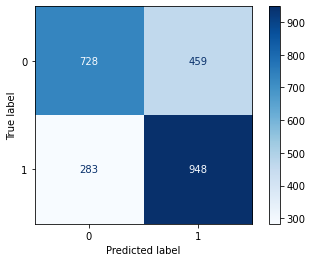

In [76]:
preds = gs.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues');


In [77]:
tvec = TfidfVectorizer()
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names())

In [78]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB() )
])

pipe_tvec_params = {
    'tvec__max_features': [5000,6000,7000],
    'tvec__stop_words': [stop_dad, stop_50,stop_100],
    'tvec__min_df': [1, 2, 3],
    'tvec__ngram_range': [(1,1), (1,2),(1,3)]
}

In [79]:
gs_tf = GridSearchCV(pipe_tvec, pipe_tvec_params, cv = 5,verbose=10)
gs_tf.fit(X_train, y_train)

gs_tf.score(X_train, y_train), gs_tf.score(X_test, y_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.713, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.710, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.708, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.711, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s


[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.703, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s


[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.707, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.4s remaining:    0.0s


[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.701, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.6s remaining:    0.0s


[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.709, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.8s remaining:    0.0s


[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.694, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son

[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.707, total=   0.5s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.713, total=   0.6s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.722, total=   0.7s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.702, total=   0.5s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.707, total=   1.0s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.709, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.705, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.710, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV] tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'] 
[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy

[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.708, total=   0.5s
[CV] tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.701, total=   1.0s
[CV] tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.697, total=   1.0s
[CV] tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.713, total=   1.0s
[CV] tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.703, total=   1.0s
[CV] tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.709, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.703, total=   0.5s
[CV] tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.706, total=   0.5s
[CV] tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.712, total=   0.6s
[CV] tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.706, total=   0.5s
[CV] tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.706, total=   1.0s
[CV] tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.710, total=   0.2s
[CV] tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.717, total=   0.2s
[CV] tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.705, total=   0.2s
[CV] tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV] tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'] 
[CV]  tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy

[CV]  tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.707, total=   0.5s
[CV] tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.705, total=   1.0s
[CV] tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.703, total=   1.0s
[CV] tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.711, total=   1.0s
[CV] tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.703, total=   0.9s
[CV] tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.711, total=   0.2s
[CV] tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.706, total=   0.5s
[CV] tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.715, total=   0.5s
[CV] tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.718, total=   0.5s
[CV] tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.717, total=   0.6s
[CV] tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.704, total=   1.2s
[CV] tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.711, total=   0.2s
[CV] tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.709, total=   0.2s
[CV] tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.704, total=   0.2s
[CV] tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.716, total=   0.2s
[CV] tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.710, total=   0.5s
[CV] tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.709, total=   1.0s
[CV] tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.716, total=   0.9s
[CV] tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.717, total=   0.2s
[CV] tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.723, total=   0.5s
[CV] tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.702, total=   0.5s
[CV] tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['da

[CV]  tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.696, total=   1.0s
[CV] tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.697, total=   0.2s
[CV] tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.718, total=   0.5s
[CV] tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.716, total=   0.5s
[CV] tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.715, total=   0.6s
[CV] tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.721, total=   0.7s
[CV] tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.711, total=   1.0s
[CV] tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.709, total=   0.2s
[CV] tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.704, total=   0.2s
[CV] tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.715, total=   0.2s
[CV] tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV] tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'] 
[CV]  tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy

[CV]  tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.716, total=   0.5s
[CV] tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.710, total=   1.2s
[CV] tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.709, total=   1.0s
[CV] tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.711, total=   1.0s
[CV] tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.713, total=   1.0s
[CV] tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:  4.0min finished


(0.8204571310373359, 0.7142266335814723)

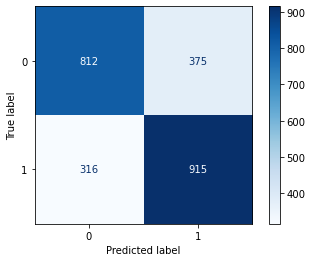

In [80]:
preds = gs_tf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(gs_tf, X_test, y_test, cmap='Blues');


In [81]:
gs_tf.best_params_

{'tvec__max_features': 7000,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': ['dad',
  'son',
  'daughter',
  'son',
  'anti',
  'antijokes',
  'antijoke']}

In [82]:
logcv_pipe = Pipeline([
    ('cvec', CountVectorizer() ),
    ('lr', LogisticRegression())
])
# pipe_logcv_params = {
#     'cvec__max_features': [2000, 3000, 4000, 5000],
#     'cvec__min_df': [1, 2, 3],
#     'cvec__max_df': [.9, .95],
#     'cvec__stop_words': [None, 'english'],
#     'cvec__ngram_range': [(1,1), (1,2), (1,3)],
#     'lr__penalty': ['none'],
#     'lr__max_iter': [50000]
# }
pipe_logcv_params = {
    'cvec__max_features': [5000,6000,7000],
    'cvec__min_df': [2, 3,4,5],
    'cvec__stop_words': [stop_dad],
    'cvec__ngram_range': [(1,3)],
    'lr__penalty': ['none'],
    'lr__max_iter': [100000],
    'lr__solver':['sag']
}

In [83]:
gs_logcv = GridSearchCV(logcv_pipe, pipe_logcv_params, cv = 5,verbose=10)

gs_logcv.fit(X_train, y_train)



Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.708, total=  12.0s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.9s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.701, total=  10.2s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.1s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.700, total=  11.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.2s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.732, total=  12.6s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   45.8s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.699, total=  12.5s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   58.3s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.707, total=  12.3s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.2min remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.703, total=  10.3s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.3min remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.700, total=  10.8s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.5min remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.731, total=  12.5s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.7min remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.702, total=  11.9s
[CV] cvec__max_features=5000, cvec__min_df=4, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 
[CV]  cvec__max_features=5000, cvec__min_df=4, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.707, total=  11.9s
[CV] cvec__max_features=5000, cvec__min_df=4, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 
[CV]  cvec__max_features=5000, cvec__min_df=4, cvec__ngram_range=(1, 3), cvec__stop_words=['dad'

[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.732, total=  12.8s
[CV] cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 
[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.702, total=  13.6s
[CV] cvec__max_features=6000, cvec__min_df=4, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 
[CV]  cvec__max_features=6000, cvec__min_df=4, cvec__ngram_range=(1, 3), cvec__stop_words=['dad'

[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.704, total=  11.0s
[CV] cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 
[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.733, total=  12.7s
[CV] cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 
[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad'

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 11.8min finished


(0.820974247595408, 0.7117452440033085)

In [ ]:
gs_logcv.score(X_train, y_train), gs_logcv.score(X_test, y_test)

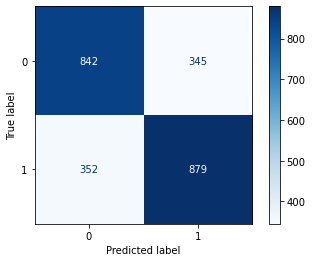

In [84]:
preds = gs_logcv.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(gs_logcv, X_test, y_test, cmap='Blues');


In [85]:
gs_logcv.best_params_

{'cvec__max_features': 7000,
 'cvec__min_df': 5,
 'cvec__ngram_range': (1, 3),
 'cvec__stop_words': ['dad',
  'son',
  'daughter',
  'son',
  'anti',
  'antijokes',
  'antijoke'],
 'lr__max_iter': 100000,
 'lr__penalty': 'none',
 'lr__solver': 'sag'}

In [86]:
for i,j in zip(gs_logcv.best_estimator_[0].get_feature_names(),gs_logcv.best_estimator_[1].coef_[0]):
    print(i,j)

000 -0.2840286388250501
000 000 -0.006937233545146395
10 -0.01310693359271324
100 -0.17576489987248278
1000 -0.06631354050868533
11 0.3951789834904464
12 0.10580732232508315
13 -0.02477923454895263
14 0.1661261877774034
15 0.07403520333761233
16 0.06773431925216654
17 -0.10419428937275732
18 -0.3081868797851786
19 -0.31863455342844343
20 -0.08194949053343138
2000 0.03893584434596052
2020 -0.17361189209153646
2021 0.04150005426279488
21 -0.006338169053477139
24 0.022869917271970568
25 0.03250912480295026
26 -0.02050769356348135
30 0.059593215048714204
35 0.021482728905226685
37 0.02113425269908381
40 -0.12860433545500466
45 -0.1305927943825731
4th 0.14465373949886465
4th of 0.12084426742188487
4th of july 0.11332587923588357
50 0.3105971969090403
50 cent 0.3010430676105094
500 0.039676757656945484
58 0.0973561981278003
60 0.010916310298142062
69 -0.042511494814665665
80 -0.3334136559462374
90 0.22313667358166062
99 0.017162185865722435
ability -0.14434879450644963
ability to -0.11393786

cookie -0.12532355331863476
cooking -0.014708427035463083
cool 0.11993658980670714
coop 0.10751136007523514
cop -0.15391837072255488
cops 0.03945696153453727
corn 0.2510478188987347
corner 0.13531358695243778
corner of -0.06396967740004558
corona -0.09979852317384275
coronavirus -0.29129141618128906
correct -0.017877401031926345
correctly -0.21652666754177022
cosby -0.13737243620515235
cost 0.08275196606265599
costs 0.03297842317477084
couch -0.11320982564212655
could 0.07263553881911344
could be -0.03478504836403714
could have 0.1035602269803989
could never 0.12881299084292358
could not -0.017542330596966433
could say 0.26694582611311496
could see -0.006547416127912536
couldn 0.1604756615440761
couldn find 0.015390821623358582
couldn see 0.11940307495567125
couldn the -0.09374215289058738
count 0.1020521020180269
counter 0.14309466138246463
counting 0.17106200322393972
countries -0.0012656626757016384
country 0.22243803584083588
couple 0.07564484467857252
couple of 0.08437664600963829

he needed 0.046179185627770715
he needs -0.018861880158671185
he never 0.017775410514218687
he not -0.07877304834430524
he only 0.03438475476292475
he opens -0.0080667639844726
he orders 0.005767627226300512
he realizes -0.03756954373897555
he really -0.0022205752652180795
he replied 0.030995880287618863
he runs 0.05661546161776294
he said 0.07580868199424788
he saw -0.16051591370200424
he says 0.045146955143833184
he sees -0.07460097883546647
he should -0.0765180016307707
he starts -0.03954535911546219
he still 0.06954176581919287
he takes 0.10766896862394304
he tells -0.0315074042479854
he the 0.09636593029670838
he then -0.09966719154865772
he thinks -0.034822859005849666
he thought 0.07385447161925283
he told 0.0632432985317107
he told me 0.007070400734789279
he took -0.08694104292399615
he tries 0.024718992392484537
he turned 0.039536406632446064
he used 0.049923087301557645
he walked 0.001391833131276164
he walks 0.02456430818906112
he wanted 0.06824265910876748
he wanted to 0.09

my father -0.04021027682526599
my favorite 0.010594551663335316
my first 0.18544504326364758
my foot -0.07043712486589637
my friend 0.309074828974796
my friend said -0.016795222593084264
my friends -0.2373114095142731
my gears -0.13984381605267648
my gf 0.04300871749644675
my girlfriend -0.31942970093411027
my god -0.10175421790707351
my grandfather -0.018604858098357085
my grandma -0.04842174661688566
my grandpa 0.04786466544275836
my hair 0.0903720955966199
my head 0.07134117586069766
my house 0.0747985507821797
my husband 0.1119354185683905
my job 0.11705975481494224
my joke 0.05943814587165566
my just 0.11162636865778201
my kid 0.07143662916812556
my kids 0.0984165257497908
my last 0.021162161095894395
my life -0.3743742508929745
my life is 0.0061985744479384815
my mind 0.0836719647229262
my mom -0.07142438822858736
my mother -0.025648015463271046
my mouth 0.15803271982618217
my name -0.05062213923426348
my name is 0.018829400285953327
my neighbor -0.1572987373993014
my new -0.0117

snail 0.060548702974898484
snake -0.181903962235208
snoop 0.09025675986685422
snow 0.30561182115168894
snowman 0.0849240466540216
so -0.10452904231571956
so asked -0.00594340652312482
so bad 0.09151961223810756
so can -0.13626006737731547
so far 0.028544942798786267
so fat -0.39211100660411885
so fat she -0.06093298909979178
so fat that -0.144285132003698
so good -0.005618956793546744
so happy -0.005314385932525234
so hard 0.02284244348422651
so he -0.06258648575284056
so he goes 0.001504212782168426
so it -0.28863107811193395
so just -0.008017379356744358
so long -0.1375422488822807
so many 0.17585341910894658
so much 0.14063770413326424
so my 0.034631196595394285
so now 0.05448399002950012
so proud 0.21424425354407153
so proud of 0.026443681248199628
so she 0.04935548708149486
so that -0.13702496594483343
so the 0.14550587641695503
so there -0.03421786659206343
so they -0.16447686732999398
so this -0.029700147955733454
so we -0.005995782181392637
so what -0.10666909002393124
so when 

until he 0.19949359183170887
until the -0.010252585533264176
up 0.08072829606056676
up an 0.03807771885844703
up and -0.07762896983493744
up as 0.02199659353412658
up for -0.10502549802768602
up from -0.14165187822105688
up he -0.043032958505912884
up his 0.08568782889971788
up in 0.02480531721392038
up in the 0.04054775960255213
up it -0.09911581994964036
up late 0.07015424037649487
up my 0.08785168767684293
up on 0.20362831695949912
up the 0.010873890256015064
up to -0.17567096800676155
up to me -0.05321763712112203
up to the 0.015954012768978405
up with 0.3151480133230978
up with this 0.15625524447179284
up your -0.020245105467433085
upon -0.28600010736520454
upper -0.15249633605742097
ups 0.1630306619632678
upset 0.024369180599479026
upvote -0.15785608784127284
upvoted -0.22785582058867151
upvotes -0.40571655006072327
ur 0.0013661355521366577
us -0.06708286784211114
us and -0.03522459312927631
usa -0.02974530897678835
use 0.12795232742050433
use of 0.08985390430050118
use the -0.22

In [88]:
logcv_orig = {'cvec__max_df': 0.9,
 'cvec__max_features': 2000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 3),
 'cvec__stop_words': None,
 'lr__max_iter': 50000,
 'lr__penalty': 'none'}

In [89]:
# dt_pipe = Pipeline([
#     ('cvec', CountVectorizer() ),
#     ('dt', DecisionTreeClassifier())
# ])

# dt_params = {'cvec__max_features': [1000,3000,5000,7000],
#              'cvec__min_df': [1, 2],
#              'cvec__stop_words': [stop_dad],
#              'cvec__ngram_range': [(1,3)],
#              'dt__max_depth': [20,25,30,35,40,45,60],
#              'dt__min_samples_split': [5, 10, 15, 20, 25, 30, 35,40,45,50],
#              'dt__min_samples_leaf': [1,2],
# }


In [90]:
# gs_dt = GridSearchCV(dt_pipe, dt_params, cv = 5,verbose=10)
# gs_dt.fit(X_train,y_train)
# gs_dt.score(X_train,y_train),gs_dt.score(X_test,y_test)

In [91]:
# gs_dt.best_params_

In [92]:
# rf_pipe = Pipeline([
#     ('cvec', CountVectorizer() ),
#     ('rf', RandomForestClassifier())
# ])
# rf_params = {'cvec__max_features': [1000, 3000,5000,7000],
#              'cvec__min_df': [1, 2],
#              'cvec__stop_words': [stop_dad],
#              'cvec__ngram_range': [(1,3)],
#              'rf__n_estimators': [500,1000,1500,2000],
#              'rf__max_depth': [15,20,25,30],
#              'rf__min_samples_split': [2,3,4,5],
#              'rf__min_samples_leaf': [2, 3],
#              'rf__max_features': ['auto']
# }


In [93]:
# gs_rf = GridSearchCV(rf_pipe, rf_params, cv = 5,verbose=10)
# gs_rf.fit(X_train,y_train)

In [94]:
# gs_rf.score(X_train,y_train),gs_dt.score(X_test,y_test)

In [22]:
Xlem = jokes_all['lemon']
ylem = jokes_all['dad']
Xlem_dj = jokes_all[jokes_all['dad'] == 1]['lemon']
ylem_dj = jokes_all[jokes_all['dad'] == 1]['dad']
Xlem_aj = jokes_all[jokes_all['dad'] == 0]['lemon']
ylem_aj = jokes_all[jokes_all['dad'] == 0]['dad']
Xlem_train, Xlem_test, ylem_train, ylem_test = train_test_split(Xlem,ylem,test_size=0.2,random_state=42)

In [23]:
cvec_lemaj = CountVectorizer(stop_words='english')
Xcv_lemaj = cvec_lemaj.fit_transform(Xlem_aj,ylem_aj)
Xcv_lemajdf = pd.DataFrame(Xcv_lemaj.todense(),columns=cvec_lemaj.get_feature_names())
Xcv_lemajdf.head()

cvec_lemdj = CountVectorizer(stop_words='english')
Xcv_lemdj = cvec_lemdj.fit_transform(Xlem_dj,ylem_dj)
Xcv_lemdjdf = pd.DataFrame(Xcv_lemdj.todense(),columns=cvec_lemdj.get_feature_names())
Xcv_lemdjdf.head()


top50_lemaj = list(Xcv_lemajdf.sum().sort_values(ascending=False).head(50).index)
top50_lemdj = list(Xcv_lemdjdf.sum().sort_values(ascending=False).head(50).index)
top100_lemaj = list(Xcv_lemajdf.sum().sort_values(ascending=False).head(100).index)
top100_lemdj = list(Xcv_lemdjdf.sum().sort_values(ascending=False).head(100).index)
stoplem_50, stoplem_100 = stop_dad[:], stop_dad[:]

for aj in top50_lemaj:
    if aj in top50_lemdj:
        stoplem_50.append(aj)
for aj in top100_lemaj:
    if aj in top100_lemdj:
        stoplem_100.append(aj)
        


In [97]:
gslem = GridSearchCV(pipe_cvnb,pipe_cvnb_params,cv =5,verbose=10)
gslem.fit(Xlem_train,ylem_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.704, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.694, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.711, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s



[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.705, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.712, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.694, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.3s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.710, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.6s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.703, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son

[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.693, total=   0.5s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.695, total=   0.5s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.711, total=   0.5s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.689, total=   0.5s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.695, total=   0.9s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.684, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.701, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.702, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.689, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.699, total=   0.5s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.678, total=   0.9s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.687, total=   0.9s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.698, total=   0.9s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.691, total=   0.9s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.683, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son

[CV]  cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.691, total=   0.5s
[CV] cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.698, total=   0.5s
[CV] cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.708, total=   0.6s
[CV] cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.694, total=   0.5s
[CV] cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.695, total=   0.9s
[CV] cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.694, total=   0.2s
[CV] cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.711, total=   0.2s
[CV] cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.705, total=   0.2s
[CV] cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.704, total=   0.2s
[CV] cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.695, total=   0.5s
[CV] cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.688, total=   0.9s
[CV] cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.691, total=   0.9s
[CV] cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.685, total=   0.2s
[CV] cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.699, total=   0.5s
[CV] cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.689, total=   0.5s
[CV] cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['da

[CV]  cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.673, total=   0.9s
[CV] cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.692, total=   0.2s
[CV] cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.684, total=   0.6s
[CV] cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.691, total=   0.6s
[CV] cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.698, total=   0.6s
[CV] cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.694, total=   0.5s
[CV] cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.695, total=   0.9s
[CV] cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.694, total=   0.2s
[CV] cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.711, total=   0.2s
[CV] cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.705, total=   0.2s
[CV] cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.704, total=   0.2s
[CV] cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.700, total=   0.5s
[CV] cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.689, total=   0.9s
[CV] cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.694, total=   0.9s
[CV] cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.685, total=   0.2s
[CV] cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.704, total=   0.5s
[CV] cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.696, total=   0.5s
[CV] cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['da

[CV]  cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.681, total=   0.9s
[CV] cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.692, total=   0.2s
[CV] cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV] cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.684, total=   0.5s
[CV] cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.691, total=   0.5s
[CV] cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], s

[CV]  cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.694, total=   0.5s
[CV] cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.695, total=   0.9s
[CV] cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:  3.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_features': [5000, 6000, 7000],
                         'cvec__min_df': [3, 5, 7],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': [['dad', 'son', 'daughter', 'son',
                                               'anti', 'antijokes',
                                               'antijoke'],
                                              ['dad', 'son', 'daughter', 'son',
                                               'anti', 'antijokes', 'antijoke',...
                                               'just', 'don', 'know', 'say',
                                               'says', 'joke', 'people', 'time',
                                               'said', 'does', 'guy', 'day',
                                               'go

In [98]:
print(gslem.score(Xlem_train, ylem_train), gslem.score(Xlem_test, ylem_test))

0.7859137449581136 0.6931348221670802


In [99]:
gslem_tf = GridSearchCV(pipe_tvec, pipe_tvec_params, cv = 5,verbose=10)
gslem_tf.fit(Xlem_train, ylem_train)

print(gslem_tf.score(Xlem_train, ylem_train), gslem_tf.score(Xlem_test, ylem_test))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.705, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.707, total=   0.3s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.708, total=   0.3s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s


[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.713, total=   0.3s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s


[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.703, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.709, total

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.4s remaining:    0.0s



[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.709, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'lik

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.8s remaining:    0.0s


[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.711, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.0s remaining:    0.0s


[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.704, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.704, total=   0.5s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.713, total=   0.5s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.704, total=   0.9s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.712, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.715, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.707, total=   0.5s
[CV] tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.707, total=   0.9s
[CV] tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.713, total=   0.9s
[CV] tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.701, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.709, total=   0.5s
[CV] tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.712, total=   0.5s
[CV] tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.707, total=   0.9s
[CV] tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.713, total=   0.2s
[CV] tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.700, total=   0.5s
[CV] tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.713, total=   0.5s
[CV] tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.717, total=   0.5s
[CV] tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.717, total=   0.5s
[CV] tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.713, total=   0.9s
[CV] tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.705, total=   0.2s
[CV] tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.713, total=   0.2s
[CV] tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.715, total=   0.2s
[CV] tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.697, total=   0.2s
[CV] tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.715, total=   0.5s
[CV] tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.702, total=   0.9s
[CV] tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.703, total=   0.9s
[CV] tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.709, total=   0.9s
[CV] tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.707, total=   0.9s
[CV] tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.714, total=   0.2s
[CV] tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.706, total=   0.5s
[CV] tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.711, total=   0.6s
[CV] tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.719, total=   0.5s
[CV] tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.717, total=   0.5s
[CV] tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.715, total=   0.9s
[CV] tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.707, total=   0.2s
[CV] tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.715, total=   0.2s
[CV] tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.715, total=   0.2s
[CV] tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.719, total=   0.2s
[CV] tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.718, total=   0.5s
[CV] tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.716, total=   0.9s
[CV] tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.721, total=   0.9s
[CV] tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.698, total=   0.2s
[CV] tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.718, total=   0.5s
[CV] tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.718, total=   0.5s
[CV] tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.711, total=   1.0s
[CV] tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.709, total=   0.2s
[CV] tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.713, total=   0.2s
[CV] tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.721, total=   0.5s
[CV] tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.719, total=   1.0s
[CV] tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.718, total=   0.9s
[CV] tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:  3.8min finished


0.8220084807115524 0.7162944582299421


In [100]:
gslem_logcv = GridSearchCV(logcv_pipe, pipe_logcv_params, cv = 5,verbose=10)

gslem_logcv.fit(Xlem_train, ylem_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.708, total=  11.4s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.704, total=   9.7s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.9s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.705, total=  11.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.1s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.732, total=  13.4s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   45.5s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.700, total=  12.9s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   58.4s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.708, total=  11.6s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.2min remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.705, total=   9.6s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.3min remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.701, total=  10.8s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.5min remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.730, total=  12.3s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.7min remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.701, total=  11.8s
[CV] cvec__max_features=5000, cvec__min_df=4, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 
[CV]  cvec__max_features=5000, cvec__min_df=4, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.710, total=  10.9s
[CV] cvec__max_features=5000, cvec__min_df=4, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 
[CV]  cvec__max_features=5000, cvec__min_df=4, cvec__ngram_range=(1, 3), cvec__stop_words=['dad'

[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.736, total=  12.5s
[CV] cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 
[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.703, total=  12.0s
[CV] cvec__max_features=6000, cvec__min_df=4, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 
[CV]  cvec__max_features=6000, cvec__min_df=4, cvec__ngram_range=(1, 3), cvec__stop_words=['dad'

[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.706, total=  11.4s
[CV] cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 
[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.734, total=  13.0s
[CV] cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 
[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad'

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 11.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_features': [5000, 6000, 7000],
                         'cvec__min_df': [2, 3, 4, 5],
                         'cvec__ngram_range': [(1, 3)],
                         'cvec__stop_words': [['dad', 'son', 'daughter', 'son',
                                               'anti', 'antijokes',
                                               'antijoke']],
                         'lr__max_iter': [100000], 'lr__penalty': ['none'],
                         'lr__solver': ['sag']},
             verbose=10)

In [101]:
print(gslem_logcv.score(Xlem_train, ylem_train), gslem_logcv.score(Xlem_test, ylem_test))

0.8229392905160823 0.7138130686517783


In [102]:
gslem_logcv.best_params_

{'cvec__max_features': 7000,
 'cvec__min_df': 4,
 'cvec__ngram_range': (1, 3),
 'cvec__stop_words': ['dad',
  'son',
  'daughter',
  'son',
  'anti',
  'antijokes',
  'antijoke'],
 'lr__max_iter': 100000,
 'lr__penalty': 'none',
 'lr__solver': 'sag'}

In [24]:
Xport = jokes_all['porter']
yport = jokes_all['dad']
Xport_dj = jokes_all[jokes_all['dad'] == 1]['porter']
yport_dj = jokes_all[jokes_all['dad'] == 1]['dad']
Xport_aj = jokes_all[jokes_all['dad'] == 0]['porter']
yport_aj = jokes_all[jokes_all['dad'] == 0]['dad']
Xport_train, Xport_test, yport_train, yport_test = train_test_split(Xport,yport,test_size=0.2,random_state=42)

In [25]:
cvec_portaj = CountVectorizer(stop_words='english')
Xcv_portaj = cvec_portaj.fit_transform(Xport_aj,yport_aj)
Xcv_portajdf = pd.DataFrame(Xcv_portaj.todense(),columns=cvec_portaj.get_feature_names())

cvec_portdj = CountVectorizer(stop_words='english')
Xcv_portdj = cvec_portdj.fit_transform(Xport_dj,yport_dj)
Xcv_portdjdf = pd.DataFrame(Xcv_portdj.todense(),columns=cvec_portdj.get_feature_names())
Xcv_portdjdf.head()


top50_portaj = list(Xcv_portajdf.sum().sort_values(ascending=False).head(50).index)
top50_portdj = list(Xcv_portdjdf.sum().sort_values(ascending=False).head(50).index)
top100_portaj = list(Xcv_portajdf.sum().sort_values(ascending=False).head(100).index)
top100_portdj = list(Xcv_portdjdf.sum().sort_values(ascending=False).head(100).index)
stopport_50, stopport_100 = stop_dad[:], stop_dad[:]

for aj in top50_portaj:
    if aj in top50_portdj:
        stopport_50.append(aj)
for aj in top100_portaj:
    if aj in top100_portdj:
        stopport_100.append(aj)
        

In [112]:
gsport = GridSearchCV(pipe_cvnb,pipe_cvnb_params,cv =5,verbose=10)
gsport.fit(Xport_train,yport_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.693, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.696, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.704, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.698, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.693, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.690, total

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.1s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.700, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.3s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.697, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.7s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.690, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son

[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.689, total=   0.6s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.695, total=   0.6s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.705, total=   0.6s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.688, total=   0.5s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.699, total=   0.9s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.686, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.688, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.694, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.681, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.706, total=   0.6s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.687, total=   0.9s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.689, total=   1.0s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.696, total=   1.0s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.693, total=   0.9s
[CV] cvec__max_features=5000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.689, total=   0.2s
[CV] cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.690, total=   0.5s
[CV] cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.685, total=   0.5s
[CV] cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.697, total=   0.5s
[CV] cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.691, total=   0.5s
[CV] cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.704, total=   1.0s
[CV] cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=5000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.693, total=   0.2s
[CV] cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.696, total=   0.2s
[CV] cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.704, total=   0.2s
[CV] cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.692, total=   0.2s
[CV] cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.705, total=   0.5s
[CV] cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.685, total=   0.9s
[CV] cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.685, total=   1.0s
[CV] cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.699, total=   1.0s
[CV] cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.688, total=   1.0s
[CV] cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV] cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.687, total=   0.2s
[CV] cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like'

[CV]  cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.691, total=   0.6s
[CV] cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.690, total=   0.5s
[CV] cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.703, total=   0.5s
[CV] cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.698, total=   0.5s
[CV] cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.706, total=   1.0s
[CV] cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=6000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.680, total=   0.2s
[CV] cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.684, total=   0.2s
[CV] cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.689, total=   0.2s
[CV] cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.679, total=   0.2s
[CV] cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.703, total=   0.5s
[CV] cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.685, total=   1.0s
[CV] cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.682, total=   1.0s
[CV] cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.706, total=   1.0s
[CV] cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.690, total=   0.9s
[CV] cvec__max_features=6000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.695, total=   0.2s
[CV] cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.696, total=   0.5s
[CV] cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.699, total=   0.5s
[CV] cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.709, total=   0.6s
[CV] cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.700, total=   0.5s
[CV] cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.704, total=   1.0s
[CV] cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.688, total=   0.2s
[CV] cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.694, total=   0.2s
[CV] cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.695, total=   0.2s
[CV] cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.681, total=   0.2s
[CV] cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.707, total=   0.5s
[CV] cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.685, total=   1.0s
[CV] cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.686, total=   1.0s
[CV] cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.707, total=   1.0s
[CV] cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.698, total=   0.9s
[CV] cvec__max_features=7000, cvec__min_df=5, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.689, total=   0.2s
[CV] cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 1), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.690, total=   0.5s
[CV] cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.685, total=   0.5s
[CV] cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.697, total=   0.5s
[CV] cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.691, total=   0.5s
[CV] cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 2), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.704, total=   1.0s
[CV] cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  cvec__max_features=7000, cvec__min_df=7, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:  3.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_features': [5000, 6000, 7000],
                         'cvec__min_df': [3, 5, 7],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': [['dad', 'son', 'daughter', 'son',
                                               'anti', 'antijokes',
                                               'antijoke'],
                                              ['dad', 'son', 'daughter', 'son',
                                               'anti', 'antijokes', 'antijoke',...
                                               'just', 'don', 'know', 'say',
                                               'says', 'joke', 'people', 'time',
                                               'said', 'does', 'guy', 'day',
                                               'go

In [113]:
print(gsport.score(Xport_train, yport_train), gsport.score(Xport_test, yport_test))

0.7844658185955115 0.6894127377998346


In [114]:
gsport.best_params_

{'cvec__max_features': 7000,
 'cvec__min_df': 5,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': ['dad',
  'son',
  'daughter',
  'son',
  'anti',
  'antijokes',
  'antijoke']}

In [115]:
gsport_tf = GridSearchCV(pipe_tvec, pipe_tvec_params, cv = 5,verbose=10)
gsport_tf.fit(Xport_train, yport_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.704, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.707, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.714, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.703, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s


[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.706, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.702, total

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.1s remaining:    0.0s


[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.710, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.3s remaining:    0.0s


[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.704, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.7s remaining:    0.0s


[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.697, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son

[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.717, total=   0.5s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.717, total=   0.5s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.711, total=   0.5s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.709, total=   0.5s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.707, total=   0.9s
[CV] tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=5000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.706, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.713, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.700, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.702, total=   0.2s
[CV] tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.707, total=   0.5s
[CV] tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.704, total=   1.0s
[CV] tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.706, total=   1.0s
[CV] tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.711, total=   1.0s
[CV] tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.703, total=   1.0s
[CV] tvec__max_features=5000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.694, total=   0.3s
[CV] tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.706, total=   0.5s
[CV] tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.715, total=   0.5s
[CV] tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.719, total=   0.6s
[CV] tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.706, total=   0.5s
[CV] tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.703, total=   0.9s
[CV] tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=5000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.708, total=   0.2s
[CV] tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.714, total=   0.2s
[CV] tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], score=0.705, total=   0.2s
[CV] tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 

[CV]  tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.703, total=   0.2s
[CV] tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.713, total=   0.5s
[CV] tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.710, total=   1.0s
[CV] tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.710, total=   0.9s
[CV] tvec__max_features=6000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.701, total=   0.2s
[CV] tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.703, total=   0.5s
[CV] tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.705, total=   0.5s
[CV] tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.703, total=   0.9s
[CV] tvec__max_features=6000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.699, total=   0.2s
[CV] tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.696, total=   0.2s
[CV] tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.706, total=   0.5s
[CV] tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.709, total=   0.9s
[CV] tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.710, total=   0.9s
[CV] tvec__max_features=6000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.710, total=   0.2s
[CV] tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.720, total=   0.5s
[CV] tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.703, total=   0.5s
[CV] tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['da

[CV]  tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.708, total=   0.9s
[CV] tvec__max_features=7000, tvec__min_df=1, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.704, total=   0.2s
[CV] tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.698, total=   0.2s
[CV] tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['da

[CV]  tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.714, total=   0.5s
[CV] tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.708, total=   0.9s
[CV] tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=7000, tvec__min_df=2, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.699, total=   0.9s
[CV] tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['da

[CV]  tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.706, total=   0.2s
[CV] tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 1), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[CV]  tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'], score=0.716, total=   0.5s
[CV] tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'got', 'didn', 'good', 'make', 'wife', 'really', 'old', 'll', 've', 'want', 'think', 'car', 'asked', 'going', 'hear'] 
[CV]  tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like

[CV]  tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 2), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.701, total=   0.6s
[CV] tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'] 
[CV]  tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['da

[CV]  tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', 'time', 'said', 'does', 'guy', 'day', 'knock', 'got', 'didn', 'good', 'make', 'wife', 'really', 'chicken', 'old', 'll', 've', 'want', 'woman', 'think', 'asks', 'car', 'asked', 'long', 'going', 'hear', 'tell', 'doesn', 'door', 'way', 'year', 'amp', 'right', 'jokes', 'dad', 'dog', 'told', 'little', 'difference', 'left', 'son', 'home', 'went', 'night', 'let', 'thing', 'person', 'doctor', 'water', 'come', 'new', 'work', 'bad', 'today', 'friend', 'best', 'need', 'goes'], score=0.706, total=   1.0s
[CV] tvec__max_features=7000, tvec__min_df=3, tvec__ngram_range=(1, 3), tvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke', 'did', 'man', 'like', 'bar', 'just', 'don', 'know', 'say', 'says', 'walks', 'joke', 'people', '

[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:  3.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [5000, 6000, 7000],
                         'tvec__min_df': [1, 2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tvec__stop_words': [['dad', 'son', 'daughter', 'son',
                                               'anti', 'antijokes',
                                               'antijoke'],
                                              ['dad', 'son', 'daughter', 'son',
                                               'anti', 'antijokes', 'antijoke',...
                                               'just', 'don', 'know', 'say',
                                               'says', 'joke', 'people', 'time',
                                               'said', 'does', 'guy', 'day',
                                               'go

In [116]:
print(gsport_tf.score(Xport_train, yport_train), gsport_tf.score(Xport_test, yport_test))

0.8196297445444203 0.7162944582299421


In [117]:
gsport_logcv = GridSearchCV(logcv_pipe, pipe_logcv_params, cv = 5,verbose=10)

gsport_logcv.fit(Xport_train, yport_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.706, total=  10.1s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.709, total=  10.5s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.5s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.704, total=  10.7s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.2s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.721, total=  10.6s
[CV] cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   41.8s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=2, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.707, total=  10.2s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   52.0s remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.705, total=  10.2s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.0min remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.710, total=  10.5s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.2min remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.703, total=  10.7s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.4min remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.722, total=  10.4s
[CV] cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.6min remaining:    0.0s


[CV]  cvec__max_features=5000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.709, total=  10.4s
[CV] cvec__max_features=5000, cvec__min_df=4, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 
[CV]  cvec__max_features=5000, cvec__min_df=4, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.709, total=  10.2s
[CV] cvec__max_features=5000, cvec__min_df=4, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 
[CV]  cvec__max_features=5000, cvec__min_df=4, cvec__ngram_range=(1, 3), cvec__stop_words=['dad'

[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.722, total=  10.6s
[CV] cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 
[CV]  cvec__max_features=6000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.709, total=  10.6s
[CV] cvec__max_features=6000, cvec__min_df=4, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 
[CV]  cvec__max_features=6000, cvec__min_df=4, cvec__ngram_range=(1, 3), cvec__stop_words=['dad'

[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.703, total=  12.2s
[CV] cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 
[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag, score=0.720, total=  11.4s
[CV] cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad', 'son', 'daughter', 'son', 'anti', 'antijokes', 'antijoke'], lr__max_iter=100000, lr__penalty=none, lr__solver=sag 
[CV]  cvec__max_features=7000, cvec__min_df=3, cvec__ngram_range=(1, 3), cvec__stop_words=['dad'

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 10.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_features': [5000, 6000, 7000],
                         'cvec__min_df': [2, 3, 4, 5],
                         'cvec__ngram_range': [(1, 3)],
                         'cvec__stop_words': [['dad', 'son', 'daughter', 'son',
                                               'anti', 'antijokes',
                                               'antijoke']],
                         'lr__max_iter': [100000], 'lr__penalty': ['none'],
                         'lr__solver': ['sag']},
             verbose=10)

In [118]:
print(gsport_logcv.score(Xport_train, yport_train), gsport_logcv.score(Xport_test, yport_test))

0.8142517323404695 0.7167080231596361


In [119]:
gsport_logcv.best_params_

{'cvec__max_features': 7000,
 'cvec__min_df': 5,
 'cvec__ngram_range': (1, 3),
 'cvec__stop_words': ['dad',
  'son',
  'daughter',
  'son',
  'anti',
  'antijokes',
  'antijoke'],
 'lr__max_iter': 100000,
 'lr__penalty': 'none',
 'lr__solver': 'sag'}

In [23]:
ftcv_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = stop_dad,ngram_range=(1,6)) ),
    ('ss', StandardScaler(with_mean=False)),
    ('lr', LogisticRegression(random_state=42,penalty = 'l1',max_iter = 100000,
                              solver = 'liblinear'))
])
# pipe_logcv_params = {
#     'cvec__max_features': [2000, 3000, 4000, 5000],
#     'cvec__min_df': [1, 2, 3],
#     'cvec__max_df': [.9, .95],
#     'cvec__stop_words': [None, 'english'],
#     'cvec__ngram_range': [(1,1), (1,2), (1,3)],
#     'lr__penalty': ['none'],
#     'lr__max_iter': [50000]
# }
pipe_ftcv_params = {
    'cvec__max_features': Integer(1,12000),
    'cvec__min_df': Integer(1,10),
    #'cvec__ngram_range': Categorical([(1,x) for x in range(1,7)]),
    'lr__C': Real(1e-5, 1e+2, prior='log-uniform')
}
bsport_tf = BayesSearchCV(ftcv_pipe, pipe_ftcv_params, cv = 5,verbose=10,
                         n_iter = 100, random_state=42,scoring = 'f1_weighted')



In [ ]:
#bsport_tf.fit(Xport_train, yport_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=4922, cvec__min_df=8, lr__C=33.89034515643755 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=4922, cvec__min_df=8, lr__C=33.89034515643755, score=0.656, total=   3.4s
[CV] cvec__max_features=4922, cvec__min_df=8, lr__C=33.89034515643755 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV]  cvec__max_features=4922, cvec__min_df=8, lr__C=33.89034515643755, score=0.644, total=   3.9s
[CV] cvec__max_features=4922, cvec__min_df=8, lr__C=33.89034515643755 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s


[CV]  cvec__max_features=4922, cvec__min_df=8, lr__C=33.89034515643755, score=0.651, total=   2.9s
[CV] cvec__max_features=4922, cvec__min_df=8, lr__C=33.89034515643755 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.3s remaining:    0.0s


[CV]  cvec__max_features=4922, cvec__min_df=8, lr__C=33.89034515643755, score=0.655, total=   3.8s
[CV] cvec__max_features=4922, cvec__min_df=8, lr__C=33.89034515643755 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   14.1s remaining:    0.0s


[CV]  cvec__max_features=4922, cvec__min_df=8, lr__C=33.89034515643755, score=0.634, total=   3.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=10049, cvec__min_df=9, lr__C=0.0013300585802877296 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=10049, cvec__min_df=9, lr__C=0.0013300585802877296, score=0.337, total=   2.4s
[CV] cvec__max_features=10049, cvec__min_df=9, lr__C=0.0013300585802877296 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV]  cvec__max_features=10049, cvec__min_df=9, lr__C=0.0013300585802877296, score=0.337, total=   2.4s
[CV] cvec__max_features=10049, cvec__min_df=9, lr__C=0.0013300585802877296 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s


[CV]  cvec__max_features=10049, cvec__min_df=9, lr__C=0.0013300585802877296, score=0.337, total=   2.4s
[CV] cvec__max_features=10049, cvec__min_df=9, lr__C=0.0013300585802877296 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.1s remaining:    0.0s


[CV]  cvec__max_features=10049, cvec__min_df=9, lr__C=0.0013300585802877296, score=0.337, total=   2.4s
[CV] cvec__max_features=10049, cvec__min_df=9, lr__C=0.0013300585802877296 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.5s remaining:    0.0s


[CV]  cvec__max_features=10049, cvec__min_df=9, lr__C=0.0013300585802877296, score=0.337, total=   2.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=5339, cvec__min_df=9, lr__C=5.420184998488358e-05 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=5339, cvec__min_df=9, lr__C=5.420184998488358e-05, score=0.337, total=   2.3s
[CV] cvec__max_features=5339, cvec__min_df=9, lr__C=5.420184998488358e-05 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV]  cvec__max_features=5339, cvec__min_df=9, lr__C=5.420184998488358e-05, score=0.337, total=   2.5s
[CV] cvec__max_features=5339, cvec__min_df=9, lr__C=5.420184998488358e-05 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.8s remaining:    0.0s


[CV]  cvec__max_features=5339, cvec__min_df=9, lr__C=5.420184998488358e-05, score=0.337, total=   2.8s
[CV] cvec__max_features=5339, cvec__min_df=9, lr__C=5.420184998488358e-05 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.7s remaining:    0.0s


[CV]  cvec__max_features=5339, cvec__min_df=9, lr__C=5.420184998488358e-05, score=0.337, total=   2.5s
[CV] cvec__max_features=5339, cvec__min_df=9, lr__C=5.420184998488358e-05 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.3s remaining:    0.0s


[CV]  cvec__max_features=5339, cvec__min_df=9, lr__C=5.420184998488358e-05, score=0.337, total=   2.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=9749, cvec__min_df=3, lr__C=0.1535781891836163 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=9749, cvec__min_df=3, lr__C=0.1535781891836163, score=0.704, total=   2.4s
[CV] cvec__max_features=9749, cvec__min_df=3, lr__C=0.1535781891836163 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV]  cvec__max_features=9749, cvec__min_df=3, lr__C=0.1535781891836163, score=0.681, total=   2.4s
[CV] cvec__max_features=9749, cvec__min_df=3, lr__C=0.1535781891836163 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s


[CV]  cvec__max_features=9749, cvec__min_df=3, lr__C=0.1535781891836163, score=0.698, total=   2.4s
[CV] cvec__max_features=9749, cvec__min_df=3, lr__C=0.1535781891836163 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.2s remaining:    0.0s


[CV]  cvec__max_features=9749, cvec__min_df=3, lr__C=0.1535781891836163, score=0.700, total=   2.5s
[CV] cvec__max_features=9749, cvec__min_df=3, lr__C=0.1535781891836163 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.7s remaining:    0.0s


[CV]  cvec__max_features=9749, cvec__min_df=3, lr__C=0.1535781891836163, score=0.688, total=   2.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=9595, cvec__min_df=5, lr__C=0.048567042731156064 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=9595, cvec__min_df=5, lr__C=0.048567042731156064, score=0.717, total=   2.3s
[CV] cvec__max_features=9595, cvec__min_df=5, lr__C=0.048567042731156064 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV]  cvec__max_features=9595, cvec__min_df=5, lr__C=0.048567042731156064, score=0.711, total=   2.4s
[CV] cvec__max_features=9595, cvec__min_df=5, lr__C=0.048567042731156064 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s


[CV]  cvec__max_features=9595, cvec__min_df=5, lr__C=0.048567042731156064, score=0.714, total=   2.4s
[CV] cvec__max_features=9595, cvec__min_df=5, lr__C=0.048567042731156064 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.1s remaining:    0.0s


[CV]  cvec__max_features=9595, cvec__min_df=5, lr__C=0.048567042731156064, score=0.715, total=   2.7s
[CV] cvec__max_features=9595, cvec__min_df=5, lr__C=0.048567042731156064 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.9s remaining:    0.0s


[CV]  cvec__max_features=9595, cvec__min_df=5, lr__C=0.048567042731156064, score=0.698, total=   2.9s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=8809, cvec__min_df=9, lr__C=0.00013971732124886836 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=8809, cvec__min_df=9, lr__C=0.00013971732124886836, score=0.337, total=   2.5s
[CV] cvec__max_features=8809, cvec__min_df=9, lr__C=0.00013971732124886836 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV]  cvec__max_features=8809, cvec__min_df=9, lr__C=0.00013971732124886836, score=0.337, total=   2.4s
[CV] cvec__max_features=8809, cvec__min_df=9, lr__C=0.00013971732124886836 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.8s remaining:    0.0s


[CV]  cvec__max_features=8809, cvec__min_df=9, lr__C=0.00013971732124886836, score=0.337, total=   2.4s
[CV] cvec__max_features=8809, cvec__min_df=9, lr__C=0.00013971732124886836 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.2s remaining:    0.0s


[CV]  cvec__max_features=8809, cvec__min_df=9, lr__C=0.00013971732124886836, score=0.337, total=   2.4s
[CV] cvec__max_features=8809, cvec__min_df=9, lr__C=0.00013971732124886836 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.6s remaining:    0.0s


[CV]  cvec__max_features=8809, cvec__min_df=9, lr__C=0.00013971732124886836, score=0.337, total=   2.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=7405, cvec__min_df=8, lr__C=0.003259571586662193 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=7405, cvec__min_df=8, lr__C=0.003259571586662193, score=0.337, total=   2.3s
[CV] cvec__max_features=7405, cvec__min_df=8, lr__C=0.003259571586662193 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV]  cvec__max_features=7405, cvec__min_df=8, lr__C=0.003259571586662193, score=0.337, total=   2.4s
[CV] cvec__max_features=7405, cvec__min_df=8, lr__C=0.003259571586662193 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s


[CV]  cvec__max_features=7405, cvec__min_df=8, lr__C=0.003259571586662193, score=0.337, total=   2.4s
[CV] cvec__max_features=7405, cvec__min_df=8, lr__C=0.003259571586662193 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.1s remaining:    0.0s


[CV]  cvec__max_features=7405, cvec__min_df=8, lr__C=0.003259571586662193, score=0.337, total=   2.3s
[CV] cvec__max_features=7405, cvec__min_df=8, lr__C=0.003259571586662193 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.5s remaining:    0.0s


[CV]  cvec__max_features=7405, cvec__min_df=8, lr__C=0.003259571586662193, score=0.337, total=   2.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=6521, cvec__min_df=9, lr__C=0.02987218052601489 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=6521, cvec__min_df=9, lr__C=0.02987218052601489, score=0.703, total=   2.4s
[CV] cvec__max_features=6521, cvec__min_df=9, lr__C=0.02987218052601489 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV]  cvec__max_features=6521, cvec__min_df=9, lr__C=0.02987218052601489, score=0.707, total=   2.8s
[CV] cvec__max_features=6521, cvec__min_df=9, lr__C=0.02987218052601489 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s


[CV]  cvec__max_features=6521, cvec__min_df=9, lr__C=0.02987218052601489, score=0.718, total=   2.7s
[CV] cvec__max_features=6521, cvec__min_df=9, lr__C=0.02987218052601489 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.9s remaining:    0.0s


[CV]  cvec__max_features=6521, cvec__min_df=9, lr__C=0.02987218052601489, score=0.723, total=   2.4s
[CV] cvec__max_features=6521, cvec__min_df=9, lr__C=0.02987218052601489 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.3s remaining:    0.0s


[CV]  cvec__max_features=6521, cvec__min_df=9, lr__C=0.02987218052601489, score=0.702, total=   2.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=11466, cvec__min_df=7, lr__C=12.634658246849666 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=11466, cvec__min_df=7, lr__C=12.634658246849666, score=0.660, total=   2.4s
[CV] cvec__max_features=11466, cvec__min_df=7, lr__C=12.634658246849666 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV]  cvec__max_features=11466, cvec__min_df=7, lr__C=12.634658246849666, score=0.631, total=   2.8s
[CV] cvec__max_features=11466, cvec__min_df=7, lr__C=12.634658246849666 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s


[CV]  cvec__max_features=11466, cvec__min_df=7, lr__C=12.634658246849666, score=0.657, total=   2.8s
[CV] cvec__max_features=11466, cvec__min_df=7, lr__C=12.634658246849666 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.0s remaining:    0.0s


[CV]  cvec__max_features=11466, cvec__min_df=7, lr__C=12.634658246849666, score=0.659, total=   3.9s
[CV] cvec__max_features=11466, cvec__min_df=7, lr__C=12.634658246849666 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.9s remaining:    0.0s


[CV]  cvec__max_features=11466, cvec__min_df=7, lr__C=12.634658246849666, score=0.644, total=   2.8s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=45, cvec__min_df=8, lr__C=1.5451804708791608 .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=45, cvec__min_df=8, lr__C=1.5451804708791608, score=0.636, total=   2.5s
[CV] cvec__max_features=45, cvec__min_df=8, lr__C=1.5451804708791608 .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV]  cvec__max_features=45, cvec__min_df=8, lr__C=1.5451804708791608, score=0.638, total=   2.5s
[CV] cvec__max_features=45, cvec__min_df=8, lr__C=1.5451804708791608 .


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s


[CV]  cvec__max_features=45, cvec__min_df=8, lr__C=1.5451804708791608, score=0.610, total=   2.6s
[CV] cvec__max_features=45, cvec__min_df=8, lr__C=1.5451804708791608 .


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.6s remaining:    0.0s


[CV]  cvec__max_features=45, cvec__min_df=8, lr__C=1.5451804708791608, score=0.638, total=   2.5s
[CV] cvec__max_features=45, cvec__min_df=8, lr__C=1.5451804708791608 .


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.1s remaining:    0.0s


[CV]  cvec__max_features=45, cvec__min_df=8, lr__C=1.5451804708791608, score=0.632, total=   2.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=80, cvec__min_df=10, lr__C=0.09836258407165276 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=80, cvec__min_df=10, lr__C=0.09836258407165276, score=0.639, total=   2.5s
[CV] cvec__max_features=80, cvec__min_df=10, lr__C=0.09836258407165276 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV]  cvec__max_features=80, cvec__min_df=10, lr__C=0.09836258407165276, score=0.642, total=   2.5s
[CV] cvec__max_features=80, cvec__min_df=10, lr__C=0.09836258407165276 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.9s remaining:    0.0s


[CV]  cvec__max_features=80, cvec__min_df=10, lr__C=0.09836258407165276, score=0.628, total=   2.5s
[CV] cvec__max_features=80, cvec__min_df=10, lr__C=0.09836258407165276 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.4s remaining:    0.0s


[CV]  cvec__max_features=80, cvec__min_df=10, lr__C=0.09836258407165276, score=0.646, total=   2.5s
[CV] cvec__max_features=80, cvec__min_df=10, lr__C=0.09836258407165276 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.9s remaining:    0.0s


[CV]  cvec__max_features=80, cvec__min_df=10, lr__C=0.09836258407165276, score=0.644, total=   2.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=12000, cvec__min_df=5, lr__C=0.04802455376713407 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=12000, cvec__min_df=5, lr__C=0.04802455376713407, score=0.717, total=   2.5s
[CV] cvec__max_features=12000, cvec__min_df=5, lr__C=0.04802455376713407 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=5, lr__C=0.04802455376713407, score=0.714, total=   2.5s
[CV] cvec__max_features=12000, cvec__min_df=5, lr__C=0.04802455376713407 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.9s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=5, lr__C=0.04802455376713407, score=0.715, total=   2.5s
[CV] cvec__max_features=12000, cvec__min_df=5, lr__C=0.04802455376713407 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.5s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=5, lr__C=0.04802455376713407, score=0.716, total=   2.5s
[CV] cvec__max_features=12000, cvec__min_df=5, lr__C=0.04802455376713407 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.0s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=5, lr__C=0.04802455376713407, score=0.697, total=   2.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=12000, cvec__min_df=1, lr__C=0.4602213184236133 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=12000, cvec__min_df=1, lr__C=0.4602213184236133, score=0.691, total=   2.6s
[CV] cvec__max_features=12000, cvec__min_df=1, lr__C=0.4602213184236133 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=1, lr__C=0.4602213184236133, score=0.679, total=   2.7s
[CV] cvec__max_features=12000, cvec__min_df=1, lr__C=0.4602213184236133 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.3s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=1, lr__C=0.4602213184236133, score=0.680, total=   2.5s
[CV] cvec__max_features=12000, cvec__min_df=1, lr__C=0.4602213184236133 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.8s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=1, lr__C=0.4602213184236133, score=0.679, total=   2.5s
[CV] cvec__max_features=12000, cvec__min_df=1, lr__C=0.4602213184236133 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.4s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=1, lr__C=0.4602213184236133, score=0.677, total=   2.8s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=12000, cvec__min_df=2, lr__C=0.039018929807693975 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=12000, cvec__min_df=2, lr__C=0.039018929807693975, score=0.715, total=   2.4s
[CV] cvec__max_features=12000, cvec__min_df=2, lr__C=0.039018929807693975 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=2, lr__C=0.039018929807693975, score=0.716, total=   2.4s
[CV] cvec__max_features=12000, cvec__min_df=2, lr__C=0.039018929807693975 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=2, lr__C=0.039018929807693975, score=0.705, total=   2.3s
[CV] cvec__max_features=12000, cvec__min_df=2, lr__C=0.039018929807693975 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.1s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=2, lr__C=0.039018929807693975, score=0.712, total=   2.4s
[CV] cvec__max_features=12000, cvec__min_df=2, lr__C=0.039018929807693975 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.5s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=2, lr__C=0.039018929807693975, score=0.700, total=   2.4s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=11735, cvec__min_df=1, lr__C=100.0 ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=11735, cvec__min_df=1, lr__C=100.0, score=0.670, total=   2.4s
[CV] cvec__max_features=11735, cvec__min_df=1, lr__C=100.0 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV]  cvec__max_features=11735, cvec__min_df=1, lr__C=100.0, score=0.654, total=   2.4s
[CV] cvec__max_features=11735, cvec__min_df=1, lr__C=100.0 ...........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s


[CV]  cvec__max_features=11735, cvec__min_df=1, lr__C=100.0, score=0.658, total=   3.4s
[CV] cvec__max_features=11735, cvec__min_df=1, lr__C=100.0 ...........


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.2s remaining:    0.0s


[CV]  cvec__max_features=11735, cvec__min_df=1, lr__C=100.0, score=0.647, total=   2.4s
[CV] cvec__max_features=11735, cvec__min_df=1, lr__C=100.0 ...........


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.6s remaining:    0.0s


[CV]  cvec__max_features=11735, cvec__min_df=1, lr__C=100.0, score=0.657, total=   2.4s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=10838, cvec__min_df=1, lr__C=4.010924278881309 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=10838, cvec__min_df=1, lr__C=4.010924278881309, score=0.678, total=   2.4s
[CV] cvec__max_features=10838, cvec__min_df=1, lr__C=4.010924278881309 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV]  cvec__max_features=10838, cvec__min_df=1, lr__C=4.010924278881309, score=0.656, total=   3.0s
[CV] cvec__max_features=10838, cvec__min_df=1, lr__C=4.010924278881309 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.3s remaining:    0.0s


[CV]  cvec__max_features=10838, cvec__min_df=1, lr__C=4.010924278881309, score=0.665, total=   2.4s
[CV] cvec__max_features=10838, cvec__min_df=1, lr__C=4.010924278881309 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.7s remaining:    0.0s


[CV]  cvec__max_features=10838, cvec__min_df=1, lr__C=4.010924278881309, score=0.660, total=   2.4s
[CV] cvec__max_features=10838, cvec__min_df=1, lr__C=4.010924278881309 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.2s remaining:    0.0s


[CV]  cvec__max_features=10838, cvec__min_df=1, lr__C=4.010924278881309, score=0.650, total=   2.4s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=12000, cvec__min_df=1, lr__C=0.0782579256493001 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=12000, cvec__min_df=1, lr__C=0.0782579256493001, score=0.708, total=   2.3s
[CV] cvec__max_features=12000, cvec__min_df=1, lr__C=0.0782579256493001 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=1, lr__C=0.0782579256493001, score=0.709, total=   2.3s
[CV] cvec__max_features=12000, cvec__min_df=1, lr__C=0.0782579256493001 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=1, lr__C=0.0782579256493001, score=0.708, total=   2.3s
[CV] cvec__max_features=12000, cvec__min_df=1, lr__C=0.0782579256493001 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.9s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=1, lr__C=0.0782579256493001, score=0.713, total=   2.3s
[CV] cvec__max_features=12000, cvec__min_df=1, lr__C=0.0782579256493001 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.3s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=1, lr__C=0.0782579256493001, score=0.690, total=   2.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=1, cvec__min_df=10, lr__C=100.0 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=1, cvec__min_df=10, lr__C=100.0, score=0.493, total=   2.2s
[CV] cvec__max_features=1, cvec__min_df=10, lr__C=100.0 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV]  cvec__max_features=1, cvec__min_df=10, lr__C=100.0, score=0.528, total=   2.3s
[CV] cvec__max_features=1, cvec__min_df=10, lr__C=100.0 ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s


[CV]  cvec__max_features=1, cvec__min_df=10, lr__C=100.0, score=0.509, total=   2.2s
[CV] cvec__max_features=1, cvec__min_df=10, lr__C=100.0 ..............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.7s remaining:    0.0s


[CV]  cvec__max_features=1, cvec__min_df=10, lr__C=100.0, score=0.542, total=   2.3s
[CV] cvec__max_features=1, cvec__min_df=10, lr__C=100.0 ..............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.0s remaining:    0.0s


[CV]  cvec__max_features=1, cvec__min_df=10, lr__C=100.0, score=0.522, total=   2.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=910, cvec__min_df=1, lr__C=26.0647066187413 ..


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=910, cvec__min_df=1, lr__C=26.0647066187413, score=0.684, total=   2.5s
[CV] cvec__max_features=910, cvec__min_df=1, lr__C=26.0647066187413 ..


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV]  cvec__max_features=910, cvec__min_df=1, lr__C=26.0647066187413, score=0.678, total=   2.9s
[CV] cvec__max_features=910, cvec__min_df=1, lr__C=26.0647066187413 ..


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.3s remaining:    0.0s


[CV]  cvec__max_features=910, cvec__min_df=1, lr__C=26.0647066187413, score=0.693, total=   2.6s
[CV] cvec__max_features=910, cvec__min_df=1, lr__C=26.0647066187413 ..


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.9s remaining:    0.0s


[CV]  cvec__max_features=910, cvec__min_df=1, lr__C=26.0647066187413, score=0.702, total=   3.0s
[CV] cvec__max_features=910, cvec__min_df=1, lr__C=26.0647066187413 ..


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.9s remaining:    0.0s


[CV]  cvec__max_features=910, cvec__min_df=1, lr__C=26.0647066187413, score=0.662, total=   2.8s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=12000, cvec__min_df=6, lr__C=0.032223782181659215 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=12000, cvec__min_df=6, lr__C=0.032223782181659215, score=0.712, total=   2.2s
[CV] cvec__max_features=12000, cvec__min_df=6, lr__C=0.032223782181659215 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=6, lr__C=0.032223782181659215, score=0.711, total=   2.3s
[CV] cvec__max_features=12000, cvec__min_df=6, lr__C=0.032223782181659215 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=6, lr__C=0.032223782181659215, score=0.712, total=   2.3s
[CV] cvec__max_features=12000, cvec__min_df=6, lr__C=0.032223782181659215 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.8s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=6, lr__C=0.032223782181659215, score=0.717, total=   2.3s
[CV] cvec__max_features=12000, cvec__min_df=6, lr__C=0.032223782181659215 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.1s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=6, lr__C=0.032223782181659215, score=0.701, total=   2.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=12000, cvec__min_df=10, lr__C=0.03781316867279462 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=12000, cvec__min_df=10, lr__C=0.03781316867279462, score=0.708, total=   2.2s
[CV] cvec__max_features=12000, cvec__min_df=10, lr__C=0.03781316867279462 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=10, lr__C=0.03781316867279462, score=0.705, total=   2.3s
[CV] cvec__max_features=12000, cvec__min_df=10, lr__C=0.03781316867279462 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=10, lr__C=0.03781316867279462, score=0.708, total=   2.3s
[CV] cvec__max_features=12000, cvec__min_df=10, lr__C=0.03781316867279462 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.8s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=10, lr__C=0.03781316867279462, score=0.717, total=   2.3s
[CV] cvec__max_features=12000, cvec__min_df=10, lr__C=0.03781316867279462 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.1s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=10, lr__C=0.03781316867279462, score=0.686, total=   2.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=12000, cvec__min_df=1, lr__C=0.2190447341391332 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=12000, cvec__min_df=1, lr__C=0.2190447341391332, score=0.692, total=   2.3s
[CV] cvec__max_features=12000, cvec__min_df=1, lr__C=0.2190447341391332 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=1, lr__C=0.2190447341391332, score=0.681, total=   2.4s
[CV] cvec__max_features=12000, cvec__min_df=1, lr__C=0.2190447341391332 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=1, lr__C=0.2190447341391332, score=0.693, total=   2.3s
[CV] cvec__max_features=12000, cvec__min_df=1, lr__C=0.2190447341391332 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.0s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=1, lr__C=0.2190447341391332, score=0.686, total=   2.3s
[CV] cvec__max_features=12000, cvec__min_df=1, lr__C=0.2190447341391332 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.3s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=1, lr__C=0.2190447341391332, score=0.682, total=   2.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=10755, cvec__min_df=1, lr__C=1.2893097450398772 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=10755, cvec__min_df=1, lr__C=1.2893097450398772, score=0.683, total=   2.3s
[CV] cvec__max_features=10755, cvec__min_df=1, lr__C=1.2893097450398772 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV]  cvec__max_features=10755, cvec__min_df=1, lr__C=1.2893097450398772, score=0.662, total=   2.3s
[CV] cvec__max_features=10755, cvec__min_df=1, lr__C=1.2893097450398772 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s


[CV]  cvec__max_features=10755, cvec__min_df=1, lr__C=1.2893097450398772, score=0.665, total=   2.4s
[CV] cvec__max_features=10755, cvec__min_df=1, lr__C=1.2893097450398772 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.0s remaining:    0.0s


[CV]  cvec__max_features=10755, cvec__min_df=1, lr__C=1.2893097450398772, score=0.672, total=   2.4s
[CV] cvec__max_features=10755, cvec__min_df=1, lr__C=1.2893097450398772 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.4s remaining:    0.0s


[CV]  cvec__max_features=10755, cvec__min_df=1, lr__C=1.2893097450398772, score=0.649, total=   2.4s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=11193, cvec__min_df=1, lr__C=1e-05 ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=11193, cvec__min_df=1, lr__C=1e-05, score=0.337, total=   2.3s
[CV] cvec__max_features=11193, cvec__min_df=1, lr__C=1e-05 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV]  cvec__max_features=11193, cvec__min_df=1, lr__C=1e-05, score=0.337, total=   2.3s
[CV] cvec__max_features=11193, cvec__min_df=1, lr__C=1e-05 ...........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s


[CV]  cvec__max_features=11193, cvec__min_df=1, lr__C=1e-05, score=0.337, total=   2.3s
[CV] cvec__max_features=11193, cvec__min_df=1, lr__C=1e-05 ...........


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.9s remaining:    0.0s


[CV]  cvec__max_features=11193, cvec__min_df=1, lr__C=1e-05, score=0.337, total=   2.3s
[CV] cvec__max_features=11193, cvec__min_df=1, lr__C=1e-05 ...........


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.2s remaining:    0.0s


[CV]  cvec__max_features=11193, cvec__min_df=1, lr__C=1e-05, score=0.337, total=   2.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=1, cvec__min_df=2, lr__C=0.05046128756105452 .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=1, cvec__min_df=2, lr__C=0.05046128756105452, score=0.493, total=   2.2s
[CV] cvec__max_features=1, cvec__min_df=2, lr__C=0.05046128756105452 .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV]  cvec__max_features=1, cvec__min_df=2, lr__C=0.05046128756105452, score=0.528, total=   2.3s
[CV] cvec__max_features=1, cvec__min_df=2, lr__C=0.05046128756105452 .


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s


[CV]  cvec__max_features=1, cvec__min_df=2, lr__C=0.05046128756105452, score=0.509, total=   2.2s
[CV] cvec__max_features=1, cvec__min_df=2, lr__C=0.05046128756105452 .


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.7s remaining:    0.0s


[CV]  cvec__max_features=1, cvec__min_df=2, lr__C=0.05046128756105452, score=0.542, total=   2.2s
[CV] cvec__max_features=1, cvec__min_df=2, lr__C=0.05046128756105452 .


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.0s remaining:    0.0s


[CV]  cvec__max_features=1, cvec__min_df=2, lr__C=0.05046128756105452, score=0.522, total=   2.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=6753, cvec__min_df=10, lr__C=0.0589719976612103 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=6753, cvec__min_df=10, lr__C=0.0589719976612103, score=0.701, total=   2.3s
[CV] cvec__max_features=6753, cvec__min_df=10, lr__C=0.0589719976612103 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV]  cvec__max_features=6753, cvec__min_df=10, lr__C=0.0589719976612103, score=0.704, total=   2.3s
[CV] cvec__max_features=6753, cvec__min_df=10, lr__C=0.0589719976612103 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s


[CV]  cvec__max_features=6753, cvec__min_df=10, lr__C=0.0589719976612103, score=0.709, total=   2.3s
[CV] cvec__max_features=6753, cvec__min_df=10, lr__C=0.0589719976612103 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.8s remaining:    0.0s


[CV]  cvec__max_features=6753, cvec__min_df=10, lr__C=0.0589719976612103, score=0.704, total=   2.3s
[CV] cvec__max_features=6753, cvec__min_df=10, lr__C=0.0589719976612103 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.2s remaining:    0.0s


[CV]  cvec__max_features=6753, cvec__min_df=10, lr__C=0.0589719976612103, score=0.684, total=   2.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=1, cvec__min_df=1, lr__C=7.448459602847577 ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=1, cvec__min_df=1, lr__C=7.448459602847577, score=0.493, total=   2.2s
[CV] cvec__max_features=1, cvec__min_df=1, lr__C=7.448459602847577 ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV]  cvec__max_features=1, cvec__min_df=1, lr__C=7.448459602847577, score=0.528, total=   2.3s
[CV] cvec__max_features=1, cvec__min_df=1, lr__C=7.448459602847577 ...


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s


[CV]  cvec__max_features=1, cvec__min_df=1, lr__C=7.448459602847577, score=0.509, total=   2.3s
[CV] cvec__max_features=1, cvec__min_df=1, lr__C=7.448459602847577 ...


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.8s remaining:    0.0s


[CV]  cvec__max_features=1, cvec__min_df=1, lr__C=7.448459602847577, score=0.542, total=   2.2s
[CV] cvec__max_features=1, cvec__min_df=1, lr__C=7.448459602847577 ...


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.1s remaining:    0.0s


[CV]  cvec__max_features=1, cvec__min_df=1, lr__C=7.448459602847577, score=0.522, total=   2.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=5811, cvec__min_df=10, lr__C=0.4469803863354628 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=5811, cvec__min_df=10, lr__C=0.4469803863354628, score=0.673, total=   2.3s
[CV] cvec__max_features=5811, cvec__min_df=10, lr__C=0.4469803863354628 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV]  cvec__max_features=5811, cvec__min_df=10, lr__C=0.4469803863354628, score=0.659, total=   2.4s
[CV] cvec__max_features=5811, cvec__min_df=10, lr__C=0.4469803863354628 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s


[CV]  cvec__max_features=5811, cvec__min_df=10, lr__C=0.4469803863354628, score=0.684, total=   2.4s
[CV] cvec__max_features=5811, cvec__min_df=10, lr__C=0.4469803863354628 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.0s remaining:    0.0s


[CV]  cvec__max_features=5811, cvec__min_df=10, lr__C=0.4469803863354628, score=0.671, total=   2.4s
[CV] cvec__max_features=5811, cvec__min_df=10, lr__C=0.4469803863354628 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.4s remaining:    0.0s


[CV]  cvec__max_features=5811, cvec__min_df=10, lr__C=0.4469803863354628, score=0.657, total=   2.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=12000, cvec__min_df=1, lr__C=29.786671014148972 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=12000, cvec__min_df=1, lr__C=29.786671014148972, score=0.668, total=   2.5s
[CV] cvec__max_features=12000, cvec__min_df=1, lr__C=29.786671014148972 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=1, lr__C=29.786671014148972, score=0.658, total=   2.4s
[CV] cvec__max_features=12000, cvec__min_df=1, lr__C=29.786671014148972 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.8s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=1, lr__C=29.786671014148972, score=0.668, total=   2.4s
[CV] cvec__max_features=12000, cvec__min_df=1, lr__C=29.786671014148972 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.2s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=1, lr__C=29.786671014148972, score=0.659, total=   2.4s
[CV] cvec__max_features=12000, cvec__min_df=1, lr__C=29.786671014148972 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.7s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=1, lr__C=29.786671014148972, score=0.657, total=   2.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=12000, cvec__min_df=10, lr__C=1.985687250568888 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=12000, cvec__min_df=10, lr__C=1.985687250568888, score=0.648, total=   2.9s
[CV] cvec__max_features=12000, cvec__min_df=10, lr__C=1.985687250568888 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=10, lr__C=1.985687250568888, score=0.633, total=   3.1s
[CV] cvec__max_features=12000, cvec__min_df=10, lr__C=1.985687250568888 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=10, lr__C=1.985687250568888, score=0.657, total=   2.7s
[CV] cvec__max_features=12000, cvec__min_df=10, lr__C=1.985687250568888 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.7s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=10, lr__C=1.985687250568888, score=0.645, total=   3.0s
[CV] cvec__max_features=12000, cvec__min_df=10, lr__C=1.985687250568888 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.7s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=10, lr__C=1.985687250568888, score=0.636, total=   2.8s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=8367, cvec__min_df=10, lr__C=0.03301187543329777 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=8367, cvec__min_df=10, lr__C=0.03301187543329777, score=0.706, total=   2.2s
[CV] cvec__max_features=8367, cvec__min_df=10, lr__C=0.03301187543329777 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV]  cvec__max_features=8367, cvec__min_df=10, lr__C=0.03301187543329777, score=0.707, total=   2.3s
[CV] cvec__max_features=8367, cvec__min_df=10, lr__C=0.03301187543329777 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s


[CV]  cvec__max_features=8367, cvec__min_df=10, lr__C=0.03301187543329777, score=0.711, total=   2.4s
[CV] cvec__max_features=8367, cvec__min_df=10, lr__C=0.03301187543329777 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.9s remaining:    0.0s


[CV]  cvec__max_features=8367, cvec__min_df=10, lr__C=0.03301187543329777, score=0.713, total=   2.3s
[CV] cvec__max_features=8367, cvec__min_df=10, lr__C=0.03301187543329777 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.3s remaining:    0.0s


[CV]  cvec__max_features=8367, cvec__min_df=10, lr__C=0.03301187543329777, score=0.691, total=   2.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=4451, cvec__min_df=1, lr__C=39.68283157482213 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=4451, cvec__min_df=1, lr__C=39.68283157482213, score=0.648, total=   4.4s
[CV] cvec__max_features=4451, cvec__min_df=1, lr__C=39.68283157482213 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


[CV]  cvec__max_features=4451, cvec__min_df=1, lr__C=39.68283157482213, score=0.624, total=   4.4s
[CV] cvec__max_features=4451, cvec__min_df=1, lr__C=39.68283157482213 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.7s remaining:    0.0s


[CV]  cvec__max_features=4451, cvec__min_df=1, lr__C=39.68283157482213, score=0.639, total=   4.4s
[CV] cvec__max_features=4451, cvec__min_df=1, lr__C=39.68283157482213 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.2s remaining:    0.0s


[CV]  cvec__max_features=4451, cvec__min_df=1, lr__C=39.68283157482213, score=0.637, total=   4.1s
[CV] cvec__max_features=4451, cvec__min_df=1, lr__C=39.68283157482213 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   17.3s remaining:    0.0s


[CV]  cvec__max_features=4451, cvec__min_df=1, lr__C=39.68283157482213, score=0.633, total=   2.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=1, cvec__min_df=1, lr__C=0.34890159204153304 .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=1, cvec__min_df=1, lr__C=0.34890159204153304, score=0.493, total=   2.3s
[CV] cvec__max_features=1, cvec__min_df=1, lr__C=0.34890159204153304 .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV]  cvec__max_features=1, cvec__min_df=1, lr__C=0.34890159204153304, score=0.528, total=   2.3s
[CV] cvec__max_features=1, cvec__min_df=1, lr__C=0.34890159204153304 .


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s


[CV]  cvec__max_features=1, cvec__min_df=1, lr__C=0.34890159204153304, score=0.509, total=   2.3s
[CV] cvec__max_features=1, cvec__min_df=1, lr__C=0.34890159204153304 .


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.8s remaining:    0.0s


[CV]  cvec__max_features=1, cvec__min_df=1, lr__C=0.34890159204153304, score=0.542, total=   2.3s
[CV] cvec__max_features=1, cvec__min_df=1, lr__C=0.34890159204153304 .


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.1s remaining:    0.0s


[CV]  cvec__max_features=1, cvec__min_df=1, lr__C=0.34890159204153304, score=0.522, total=   2.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=12000, cvec__min_df=10, lr__C=0.14472470656561695 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cvec__max_features=12000, cvec__min_df=10, lr__C=0.14472470656561695, score=0.683, total=   2.3s
[CV] cvec__max_features=12000, cvec__min_df=10, lr__C=0.14472470656561695 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=10, lr__C=0.14472470656561695, score=0.688, total=   2.3s
[CV] cvec__max_features=12000, cvec__min_df=10, lr__C=0.14472470656561695 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=10, lr__C=0.14472470656561695, score=0.691, total=   2.3s
[CV] cvec__max_features=12000, cvec__min_df=10, lr__C=0.14472470656561695 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.9s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=10, lr__C=0.14472470656561695, score=0.692, total=   2.3s
[CV] cvec__max_features=12000, cvec__min_df=10, lr__C=0.14472470656561695 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.2s remaining:    0.0s


[CV]  cvec__max_features=12000, cvec__min_df=10, lr__C=0.14472470656561695, score=0.670, total=   2.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] cvec__max_features=12000, cvec__min_df=10, lr__C=66.87289823834739 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
#print(bsport_tf.score(Xport_train, yport_train), bsport_tf.score(Xport_test, yport_test))

In [26]:
Xport = jokes_all[['porter','ft_wc','ft_length','sent_compound','sent_pos','sent_neg','sent_neu']]
yport = jokes_all['dad']

Xport_train, Xport_test, yport_train, yport_test = train_test_split(Xport,yport,test_size=0.2,random_state=42)

In [27]:
Xport.shape,Xport_train.shape

((12087, 7), (9669, 7))

In [28]:
cv_port = TfidfVectorizer(min_df=4,ngram_range=(1,6),stop_words=stop_dad)
Xport_train_cv = cv_port.fit_transform(Xport_train['porter'],yport_train)
Xport_train_df = pd.DataFrame(Xport_train_cv.todense(),columns=cv_port.get_feature_names()).reset_index()
Xport_train_sent = Xport_train[['ft_wc','ft_length','sent_compound','sent_pos','sent_neg','sent_neu']].reset_index()
Xport_train_df = pd.concat([Xport_train_df,Xport_train_sent],axis = 1)

Xport_test_cv = cv_port.transform(Xport_test['porter'])
Xport_test_df = pd.DataFrame(Xport_test_cv.todense(),columns=cv_port.get_feature_names()).reset_index()
Xport_test_sent = Xport_test[['ft_wc','ft_length','sent_compound','sent_pos','sent_neg','sent_neu']].reset_index()
Xport_test_df = pd.concat([Xport_test_df,Xport_test_sent],axis = 1)
print(Xport_train_df.shape,Xport_test_df.shape)


(9669, 15203) (2418, 15203)


In [99]:
Xport_train_df.isnull().sum().sum()

0

In [29]:
ss = StandardScaler(with_mean=False)
gcv_pipe = Pipeline([
    ('ss', StandardScaler(with_mean = False)),
    ('lr', LogisticRegression(random_state=42,penalty = 'l1',max_iter = 100000,
                              solver = 'liblinear'))
])
gcv_sent_params = {
    'lr__C': np.logspace(-5,5,100)
}
gcv_sent = GridSearchCV(gcv_pipe,gcv_sent_params, cv = 5,verbose=10)



In [30]:
gcv_sent.fit(Xport_train_df,yport_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] lr__C=1e-05 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......................... lr__C=1e-05, score=0.503, total=   5.1s
[CV] lr__C=1e-05 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


[CV] ......................... lr__C=1e-05, score=0.503, total=   5.4s
[CV] lr__C=1e-05 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.5s remaining:    0.0s


[CV] ......................... lr__C=1e-05, score=0.503, total=   5.2s
[CV] lr__C=1e-05 .....................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.8s remaining:    0.0s


[CV] ......................... lr__C=1e-05, score=0.503, total=   5.3s
[CV] lr__C=1e-05 .....................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   21.1s remaining:    0.0s


[CV] ......................... lr__C=1e-05, score=0.503, total=   5.5s
[CV] lr__C=1.2618568830660211e-05 ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.7s remaining:    0.0s


[CV] ........ lr__C=1.2618568830660211e-05, score=0.503, total=   6.1s
[CV] lr__C=1.2618568830660211e-05 ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   32.8s remaining:    0.0s


[CV] ........ lr__C=1.2618568830660211e-05, score=0.503, total=   6.6s
[CV] lr__C=1.2618568830660211e-05 ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   39.5s remaining:    0.0s


[CV] ........ lr__C=1.2618568830660211e-05, score=0.503, total=   6.9s
[CV] lr__C=1.2618568830660211e-05 ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   46.4s remaining:    0.0s


[CV] ........ lr__C=1.2618568830660211e-05, score=0.503, total=   7.4s
[CV] lr__C=1.2618568830660211e-05 ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   53.9s remaining:    0.0s


[CV] ........ lr__C=1.2618568830660211e-05, score=0.503, total=   6.1s
[CV] lr__C=1.5922827933410938e-05 ....................................
[CV] ........ lr__C=1.5922827933410938e-05, score=0.503, total=   6.3s
[CV] lr__C=1.5922827933410938e-05 ....................................
[CV] ........ lr__C=1.5922827933410938e-05, score=0.503, total=   6.3s
[CV] lr__C=1.5922827933410938e-05 ....................................
[CV] ........ lr__C=1.5922827933410938e-05, score=0.503, total=   6.7s
[CV] lr__C=1.5922827933410938e-05 ....................................
[CV] ........ lr__C=1.5922827933410938e-05, score=0.503, total=   6.7s
[CV] lr__C=1.5922827933410938e-05 ....................................
[CV] ........ lr__C=1.5922827933410938e-05, score=0.503, total=   6.9s
[CV] lr__C=2.0092330025650458e-05 ....................................
[CV] ........ lr__C=2.0092330025650458e-05, score=0.503, total=   7.1s
[CV] lr__C=2.0092330025650458e-05 ....................................
[CV] .

[CV] ........ lr__C=0.00020565123083486514, score=0.503, total=   6.9s
[CV] lr__C=0.00020565123083486514 ....................................
[CV] ........ lr__C=0.00020565123083486514, score=0.503, total=   6.8s
[CV] lr__C=0.00020565123083486514 ....................................
[CV] ........ lr__C=0.00020565123083486514, score=0.503, total=   6.8s
[CV] lr__C=0.00025950242113997375 ....................................
[CV] ........ lr__C=0.00025950242113997375, score=0.503, total=   7.2s
[CV] lr__C=0.00025950242113997375 ....................................
[CV] ........ lr__C=0.00025950242113997375, score=0.503, total=   6.9s
[CV] lr__C=0.00025950242113997375 ....................................
[CV] ........ lr__C=0.00025950242113997375, score=0.503, total=   6.8s
[CV] lr__C=0.00025950242113997375 ....................................
[CV] ........ lr__C=0.00025950242113997375, score=0.503, total=   6.9s
[CV] lr__C=0.00025950242113997375 ....................................
[CV] .

[CV] .......... lr__C=0.003351602650938841, score=0.951, total=   6.8s
[CV] lr__C=0.003351602650938841 ......................................
[CV] .......... lr__C=0.003351602650938841, score=0.955, total=   7.1s
[CV] lr__C=0.003351602650938841 ......................................
[CV] .......... lr__C=0.003351602650938841, score=0.956, total=   6.8s
[CV] lr__C=0.003351602650938841 ......................................
[CV] .......... lr__C=0.003351602650938841, score=0.949, total=   6.8s
[CV] lr__C=0.003351602650938841 ......................................
[CV] .......... lr__C=0.003351602650938841, score=0.952, total=   6.8s
[CV] lr__C=0.0042292428743894986 .....................................
[CV] ......... lr__C=0.0042292428743894986, score=0.963, total=   7.0s
[CV] lr__C=0.0042292428743894986 .....................................
[CV] ......... lr__C=0.0042292428743894986, score=0.967, total=   7.0s
[CV] lr__C=0.0042292428743894986 .....................................
[CV] .

[CV] ........... lr__C=0.04328761281083057, score=0.989, total=   5.6s
[CV] lr__C=0.04328761281083057 .......................................
[CV] ........... lr__C=0.04328761281083057, score=0.995, total=   5.6s
[CV] lr__C=0.05462277217684343 .......................................
[CV] ........... lr__C=0.05462277217684343, score=0.991, total=   5.9s
[CV] lr__C=0.05462277217684343 .......................................
[CV] ........... lr__C=0.05462277217684343, score=0.994, total=   6.3s
[CV] lr__C=0.05462277217684343 .......................................
[CV] ........... lr__C=0.05462277217684343, score=0.989, total=   5.9s
[CV] lr__C=0.05462277217684343 .......................................
[CV] ........... lr__C=0.05462277217684343, score=0.988, total=   6.5s
[CV] lr__C=0.05462277217684343 .......................................
[CV] ........... lr__C=0.05462277217684343, score=0.995, total=   6.6s
[CV] lr__C=0.06892612104349695 .......................................
[CV] .

[CV] ............ lr__C=0.7054802310718645, score=0.981, total=   6.9s
[CV] lr__C=0.7054802310718645 ........................................
[CV] ............ lr__C=0.7054802310718645, score=0.984, total=   6.9s
[CV] lr__C=0.7054802310718645 ........................................
[CV] ............ lr__C=0.7054802310718645, score=0.979, total=   7.2s
[CV] lr__C=0.7054802310718645 ........................................
[CV] ............ lr__C=0.7054802310718645, score=0.980, total=   7.1s
[CV] lr__C=0.8902150854450392 ........................................
[CV] ............ lr__C=0.8902150854450392, score=0.975, total=   6.9s
[CV] lr__C=0.8902150854450392 ........................................
[CV] ............ lr__C=0.8902150854450392, score=0.977, total=   6.9s
[CV] lr__C=0.8902150854450392 ........................................
[CV] ............ lr__C=0.8902150854450392, score=0.981, total=   6.9s
[CV] lr__C=0.8902150854450392 ........................................
[CV] .

[CV] ............. lr__C=9.111627561154886, score=0.937, total=   7.0s
[CV] lr__C=11.497569953977356 ........................................
[CV] ............ lr__C=11.497569953977356, score=0.926, total=   6.9s
[CV] lr__C=11.497569953977356 ........................................
[CV] ............ lr__C=11.497569953977356, score=0.961, total=   7.0s
[CV] lr__C=11.497569953977356 ........................................
[CV] ............ lr__C=11.497569953977356, score=0.938, total=   6.9s
[CV] lr__C=11.497569953977356 ........................................
[CV] ............ lr__C=11.497569953977356, score=0.931, total=   7.1s
[CV] lr__C=11.497569953977356 ........................................
[CV] ............ lr__C=11.497569953977356, score=0.928, total=   6.9s
[CV] lr__C=14.508287784959402 ........................................
[CV] ............ lr__C=14.508287784959402, score=0.952, total=   6.8s
[CV] lr__C=14.508287784959402 ........................................
[CV] .

[CV] ............ lr__C=148.49682622544634, score=0.873, total=   6.9s
[CV] lr__C=148.49682622544634 ........................................
[CV] ............ lr__C=148.49682622544634, score=0.798, total=   6.7s
[CV] lr__C=148.49682622544634 ........................................
[CV] ............ lr__C=148.49682622544634, score=0.764, total=   6.8s
[CV] lr__C=187.3817422860383 .........................................
[CV] ............. lr__C=187.3817422860383, score=0.777, total=   6.8s
[CV] lr__C=187.3817422860383 .........................................
[CV] ............. lr__C=187.3817422860383, score=0.787, total=   6.7s
[CV] lr__C=187.3817422860383 .........................................
[CV] ............. lr__C=187.3817422860383, score=0.790, total=   6.7s
[CV] lr__C=187.3817422860383 .........................................
[CV] ............. lr__C=187.3817422860383, score=0.782, total=   6.7s
[CV] lr__C=187.3817422860383 .........................................
[CV] .

[CV] ............ lr__C=2420.1282647943835, score=0.744, total=   6.2s
[CV] lr__C=2420.1282647943835 ........................................
[CV] ............ lr__C=2420.1282647943835, score=0.738, total=   6.4s
[CV] lr__C=2420.1282647943835 ........................................
[CV] ............ lr__C=2420.1282647943835, score=0.731, total=   6.5s
[CV] lr__C=2420.1282647943835 ........................................
[CV] ............ lr__C=2420.1282647943835, score=0.723, total=   6.8s
[CV] lr__C=2420.1282647943835 ........................................
[CV] ............ lr__C=2420.1282647943835, score=0.755, total=   6.4s
[CV] lr__C=3053.8555088334124 ........................................
[CV] ............ lr__C=3053.8555088334124, score=0.742, total=   6.2s
[CV] lr__C=3053.8555088334124 ........................................
[CV] ............ lr__C=3053.8555088334124, score=0.736, total=   6.7s
[CV] lr__C=3053.8555088334124 ........................................
[CV] .

[CV] ............. lr__C=31257.15849688235, score=0.707, total=   6.4s
[CV] lr__C=31257.15849688235 .........................................
[CV] ............. lr__C=31257.15849688235, score=0.712, total=   6.3s
[CV] lr__C=39442.06059437648 .........................................
[CV] ............. lr__C=39442.06059437648, score=0.726, total=   6.7s
[CV] lr__C=39442.06059437648 .........................................
[CV] ............. lr__C=39442.06059437648, score=0.760, total=   6.4s
[CV] lr__C=39442.06059437648 .........................................
[CV] ............. lr__C=39442.06059437648, score=0.718, total=   6.4s
[CV] lr__C=39442.06059437648 .........................................
[CV] ............. lr__C=39442.06059437648, score=0.705, total=   6.3s
[CV] lr__C=39442.06059437648 .........................................
[CV] ............. lr__C=39442.06059437648, score=0.712, total=   6.4s
[CV] lr__C=49770.23564332114 .........................................
[CV] .

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 56.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler(with_mean=False)),
                                       ('lr',
                                        LogisticRegression(max_iter=100000,
                                                           penalty='l1',
                                                           random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'lr__C': array([1.00000000e-05, 1.26185688e-05, 1.59228279e-05, 2.00923300e-05,
       2.53536449e-05, 3.19926714e-05, 4.03701726e-05, 5.09413801e-05,
       6.42807312e-05, 8.11130831e-...
       4.75081016e+02, 5.99484250e+02, 7.56463328e+02, 9.54548457e+02,
       1.20450354e+03, 1.51991108e+03, 1.91791026e+03, 2.42012826e+03,
       3.05385551e+03, 3.85352859e+03, 4.86260158e+03, 6.13590727e+03,
       7.74263683e+03, 9.77009957e+03, 1.23284674e+04, 1.55567614e+04,
       1.96304065e+04, 2.47707636e+04, 3.1257158

In [ ]:
{'cvec__max_features': 7000,
 'cvec__min_df': 4,
 'cvec__ngram_range': (1, 3),
 'cvec__stop_words': ['dad',
  'son',
  'daughter',
  'son',
  'anti',
  'antijokes',
  'antijoke'],
 'lr__max_iter': 100000,
 'lr__penalty': 'none',
 'lr__solver': 'sag'}

In [31]:
print(gcv_sent.score(Xport_train_df, yport_train), gcv_sent.score(Xport_test_df, yport_test))

0.9987589202606267 0.9917287014061208


In [108]:
gcv_sent.best_params_

{'lr__C': 5.72236765935022}

In [41]:
fit_list = []
for i,j in zip(cv_port.get_feature_names(),gcv_sent.best_estimator_[1].coef_[0]):
    if j != 0:
        fit_list.append([i,j])
sorted_fit = sorted(fit_list, key=lambda x:abs(x[1]))        
len(sorted_fit),sorted_fit[::-1]


(246,
 [['and 10', -0.15770538243314486],
  ['my 10', 0.06920214310143298],
  ['wa abl', 0.05665405297076747],
  ['the chicken cross the road becaus', -0.052947386214895996],
  ['the bartend and', -0.0461348768654213],
  ['black and', -0.044518571294153646],
  ['it about', 0.03143326423595124],
  ['hate it', 0.03130045282056362],
  ['you could say', 0.027557905432982352],
  ['poop on', -0.0266063012774957],
  ['where are', 0.024607302892699252],
  ['probabl be', -0.02455805558350392],
  ['your age', -0.02443417376785111],
  ['crash', 0.024374322756882044],
  ['now and', 0.02340016127313876],
  ['our', -0.022501308753102692],
  ['have anoth', -0.02218389891061629],
  ['cost', -0.02202108046384978],
  ['fix hi', 0.021713441731407254],
  ['apparently', 0.020601148596235602],
  ['hear about the guy', 0.019533606993054245],
  ['job at', 0.018833882767076458],
  ['joke will', 0.018553172013120737],
  ['50 cent do', 0.017320781177174765],
  ['you lost', -0.017137723562790537],
  ['will ever',

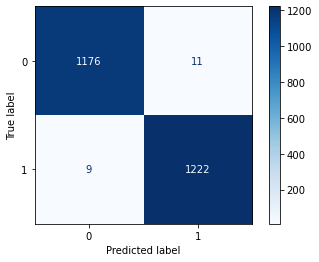

In [43]:
preds = gcv_sent.predict(Xport_test_df)

tn, fp, fn, tp = confusion_matrix(yport_test, preds).ravel()
plot_confusion_matrix(gcv_sent, Xport_test_df, yport_test, cmap='Blues');
